multiple window sizes.
idea is to have a couple of tcn with diffrent sizes
output of those will go to NN

     ---window size 10-- tcn --
     ---window size 30-- tcn --
input---window size 50-- tcn --  NN   -- result
     ---window size 80-- tcn --
     ---window size 99-- tcn --

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tcn', '/content/drive/My Drive/Fax/Master Theses/keras-tcn-master/tcn/tcn.py').load_module()

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from sklearn import preprocessing

import os
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.models import Sequential,load_model, model_from_json

from tcn import TCN

In [0]:
# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/output-tcn-6'

data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'

  

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:

#MAXLIFE = 120
MAXLIFE = 137
def kink_RUL(cycle_list, max_cycle):
    '''
    Piecewise linear function with zero gradient and unit gradient

            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_point = max_cycle - MAXLIFE
    if knee_point <= 0:
      knee_point = 1
      
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    return kink_RUL


def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)


def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD001, output a list
    '''
    rul = []
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
        return rul
    else:
        rul = []
        for _id in set(FD00X[id]):
            # print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul


In [0]:

rul=[]

for id in train_df['id'].unique():
  rul.extend(compute_rul_of_one_id (train_df[train_df['id']== id]))

In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
#rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
#rul.columns = ['id', 'max']
#train_df = train_df.merge(rul, on=['id'], how='left')
#train_df['RUL'] = train_df['max'] - train_df['cycle']
#train_df.drop('max', axis=1, inplace=True)
train_df['RUL']= rul

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [9]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [0]:
# pick a large window size of 50 cycles
#sequence_length = 32
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
  
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
  
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]


# generator for the sequences
# transform each id of the train dataset in a sequence
def get_seq(sequence_length):
  seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
            for id in train_df['id'].unique())
  seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
  print(seq_array.shape)
  return seq_array

# generate labels
def get_lebels(sequence_length):
  label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
              for id in train_df['id'].unique()]

  label_array = np.concatenate(label_gen).astype(np.float32)
  return label_array

In [11]:
seq_array1 =  get_seq(10)
seq_array2 =  get_seq(30)
seq_array3 =  get_seq(50)
seq_array4 =  get_seq(70)
seq_array5 =  get_seq(90)

label_array1 = get_lebels(10)
label_array2 = get_lebels(30)
label_array3 = get_lebels(50)
label_array4 = get_lebels(70)
label_array5 = get_lebels(90)

(19631, 10, 25)
(17631, 30, 25)
(15631, 50, 25)
(13631, 70, 25)
(11631, 90, 25)


In [0]:

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
##output tcn-6
def train_model(seq_array, label_array, id):
  
  model_path = output_path+'/tcn_model'+ id +'.h5'
  print(model_path)
  nb_features = seq_array.shape[2]
  nb_out = label_array.shape[1]
  sequence_length = seq_array.shape[1]

  i = Input(shape=(sequence_length, nb_features))

  #m = TCN(nb_filters=12,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=True)(i)
  #m = TCN(nb_filters=6,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=False)(m)

  m = TCN(nb_filters=12,dropout_rate = 0.2,return_sequences=True)(i)
  m = TCN(nb_filters=6,dropout_rate = 0.2,return_sequences=False)(m)
  m = Dense(1, activation='linear')(m)
  model = Model(inputs=[i], outputs=[m])
  model.summary()

  model.compile('adam', 'mae')
  model.compile(loss=root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])

  history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
            callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
            )
  return history, model

In [0]:
history1,model1 = train_model(seq_array1, label_array1, '1')

/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_model1.h5
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 25)]          0         
_________________________________________________________________
tcn_8 (TCN)                  (None, 10, 12)            4692      
_________________________________________________________________
tcn_9 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________
Train on 18649 samples, validate on 982 samples
Epoch 1/100
18649/18649 - 16s - loss: 60.8301 - mae: 49.3450 - r2_keras: -8.4247e-01 - root_mean_squared_error: 60.7088 - val_loss: 41.915

In [0]:
def plot_stats(history, model,id,seq_array,label_array):
  # list all data in history
  print(history.history.keys())

  # summarize history for R^2
  fig_acc = plt.figure(figsize=(10, 10))
  plt.plot(history.history['r2_keras'])
  plt.plot(history.history['val_r2_keras'])
  plt.title('model r^2')
  plt.ylabel('R^2')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  fig_acc.savefig(output_path+"/model"+id+"_r2.png")

  # summarize history for MAE
  fig_acc = plt.figure(figsize=(10, 10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  fig_acc.savefig(output_path+"/model"+id+"_mae.png")


  # summarize history for RMSE
  fig_acc = plt.figure(figsize=(10, 10))
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('model RMSE')
  plt.ylabel('RMSE')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  fig_acc.savefig(output_path+"/model"+id+"_mae.png")

  # summarize history for Loss
  fig_acc = plt.figure(figsize=(10, 10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  fig_acc.savefig(output_path+"/model"+id+"_regression_loss.png")

  # training metrics
  scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
  print('\nMAE: {}'.format(scores[1]))
  print('\nR^2: {}'.format(scores[2]))
  print('\nRMSE: {}'.format(scores[3]))

  y_pred = model.predict(seq_array,verbose=1, batch_size=200)
  y_true = label_array



dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


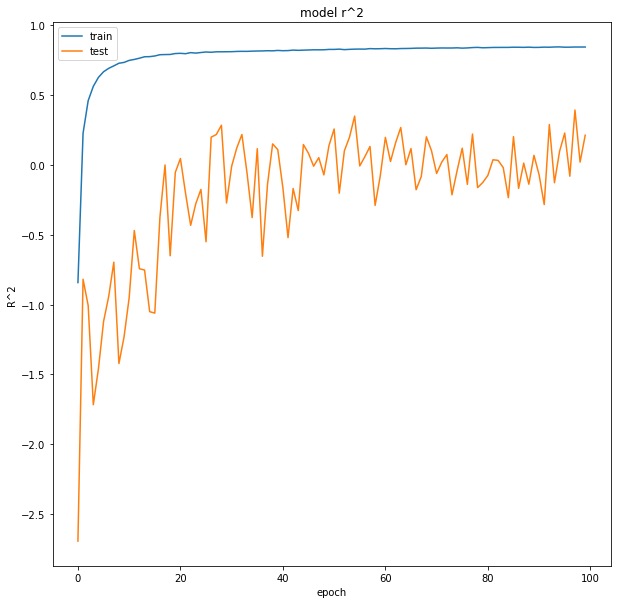

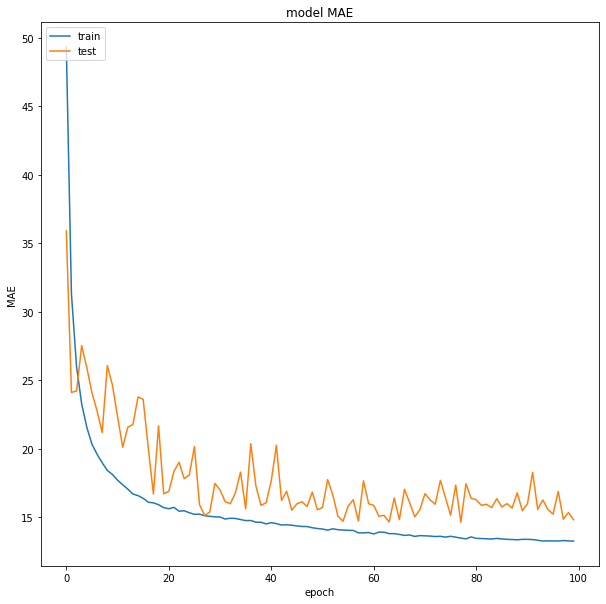

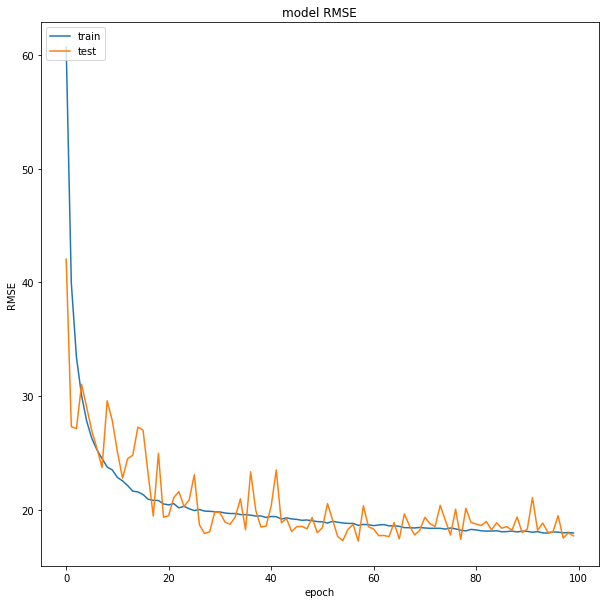

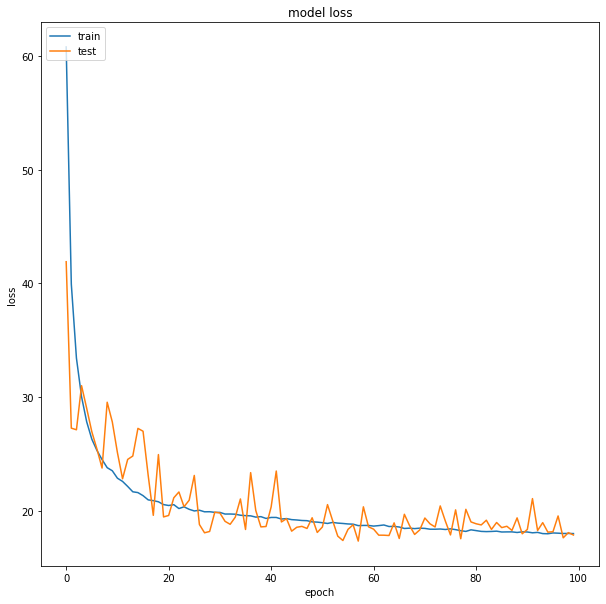

19631/19631 [==============================] - 2s 118us/sample - loss: 15.7647 - mae: 12.4820 - r2_keras: 0.5864 - root_mean_squared_error: 15.6644

MAE: 12.481999397277832

R^2: 0.5863557457923889

RMSE: 15.66438102722168
19631/19631 [==============================] - 3s 150us/sample


In [0]:
plot_stats(history1,model1,'1', seq_array1,label_array1)

In [0]:
##################################
# EVALUATE ON TEST DATA
##################################
def evaluate_on_test_data(model_path,id,sequence_length ):
  # We pick the last sequence for each id in the test data
  seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

  seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
  print("seq_array_test_last")
  print(seq_array_test_last.shape)

  # Similarly, we pick the labels
  #print("y_mask")
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
  label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
  print(label_array_test_last.shape)
  #print("label_array_test_last")
  #print(label_array_test_last)

  # if best iteration's model was saved then load and use it
  if os.path.isfile(model_path):

      # restore weights
      estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error': root_mean_squared_error,'TCN': TCN})

      
      # test metrics
      scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
      print('\nMAE: {}'.format(scores_test[1]))
      print('\nR^2: {}'.format(scores_test[2]))
      print('\nRMSE: {}'.format(scores_test[3]))

      y_pred_test = estimator.predict(seq_array_test_last)
      y_true_test = label_array_test_last

      test_set = pd.DataFrame(y_pred_test)
      test_set.to_csv(output_path+'/submit_test'+id+'.csv', index = None)



      result = pd.DataFrame( columns = ['pred', 'true']) 
      result['pred'] = y_pred_test.flatten().round()
      result['true'] = y_true_test.flatten()
      result.sort_values(by='true', inplace=True)
      # Plot in blue color the predicted data and in orange color the
      # actual data to verify visually the accuracy of the model.
          
      x = np.arange(len(y_pred_test))
      width = 0.35  # the width of the bars

      fig, ax = plt.subplots(figsize=(100, 50))
      rects1 = ax.bar(x - width/2,result['pred'], width, label='predicted')
      rects2 = ax.bar(x + width/2,result['true'], width, label='true')

      # Add some text for labels, title and custom x-axis tick labels, etc.
      ax.set_ylabel('value')
      ax.set_title('prediction')
      ax.set_xticks(x)
      ax.legend()


      def autolabel(rects):
          """Attach a text label above each bar in *rects*, displaying its height."""
          for rect in rects:
              height = rect.get_height()
              ax.annotate('{}'.format(height),
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom')


      autolabel(rects1)
      autolabel(rects2)

      plt.show()
      fig.savefig(output_path+"/model"+id+"_verify_bar.png")

seq_array_test_last
(100, 10, 25)
(100, 1)
100/100 - 1s - loss: 19.0114 - mae: 14.0432 - r2_keras: 0.8028 - root_mean_squared_error: 17.2029

MAE: 14.043157577514648

R^2: 0.8027997016906738

RMSE: 17.202922821044922


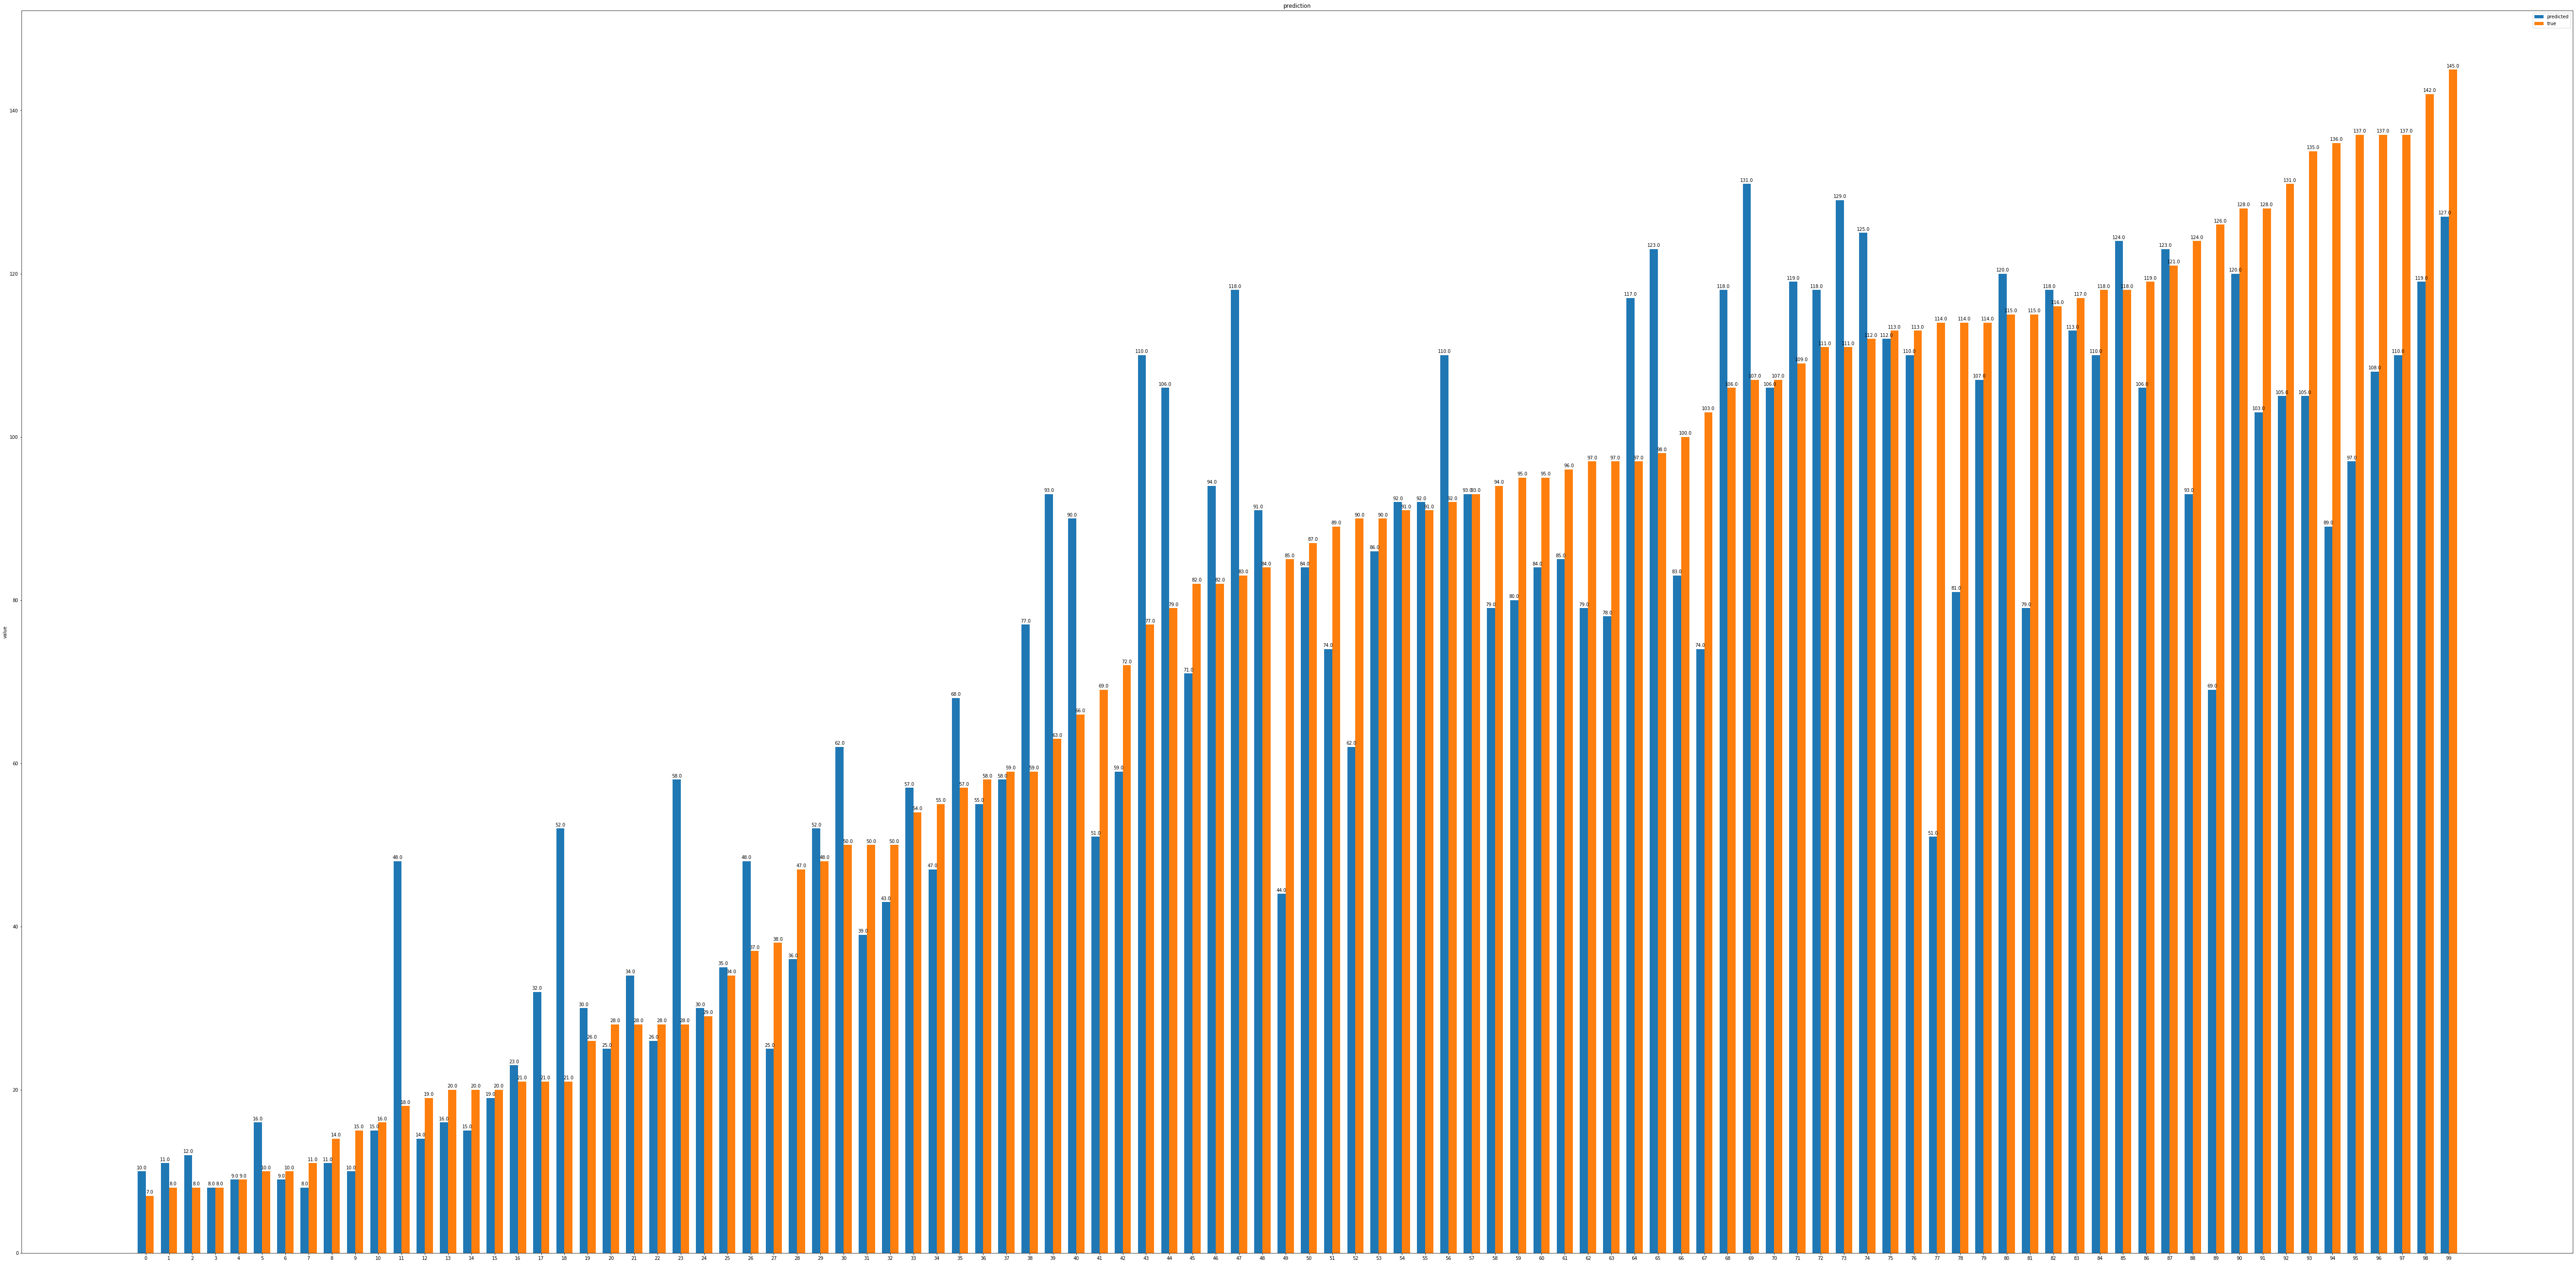

In [0]:

model_path = output_path+'/tcn_model1.h5'
evaluate_on_test_data(model_path,'1',10 )

In [0]:
def train_tcn(id,seq_array,label_array):
  id = str(id)
  sequence_length = seq_array.shape[1]
  model_path = output_path+'/tcn_model'+ id +'.h5'

  history, model = train_model(seq_array, label_array, id)
  plot_stats(history,model,id, seq_array,label_array)
  evaluate_on_test_data(model_path,id,sequence_length )

/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_model2.h5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 25)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 30, 12)            4692      
_________________________________________________________________
tcn_1 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________
Train on 16749 samples, validate on 882 samples
Epoch 1/100
16749/16749 - 16s - loss: 70.2150 - mae: 54.7554 - r2_keras: -2.5908e+00 - root_mean_squared_error: 70.1490 - val_loss: 51.2327 

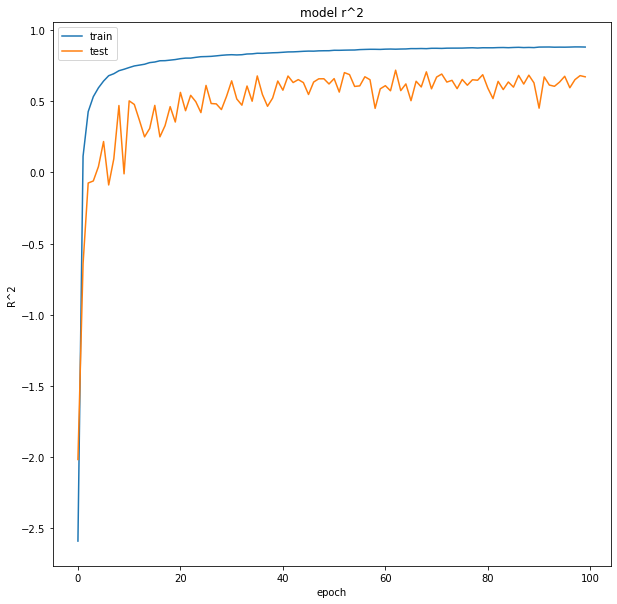

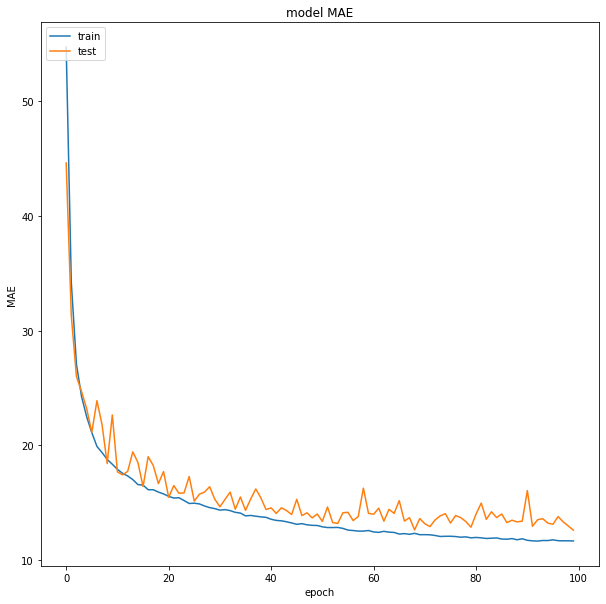

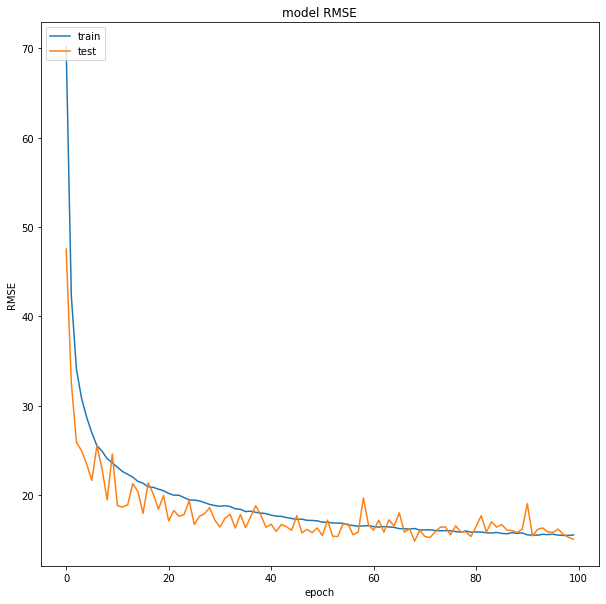

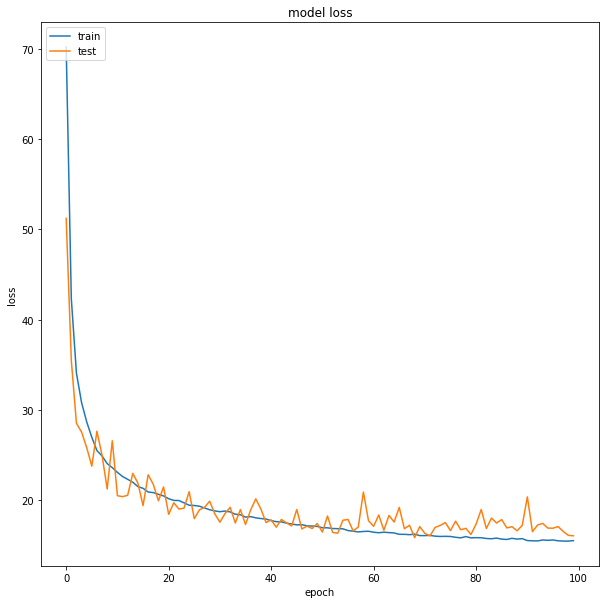

17631/17631 [==============================] - 3s 176us/sample - loss: 15.2007 - mae: 12.1196 - r2_keras: -0.5283 - root_mean_squared_error: 15.0834

MAE: 12.119608879089355

R^2: -0.5282519459724426

RMSE: 15.083433151245117
17631/17631 [==============================] - 4s 207us/sample
seq_array_test_last
(100, 30, 25)
(100, 1)
100/100 - 1s - loss: 14.9431 - mae: 11.2934 - r2_keras: 0.8687 - root_mean_squared_error: 13.8095

MAE: 11.293447494506836

R^2: 0.8686798810958862

RMSE: 13.809491157531738


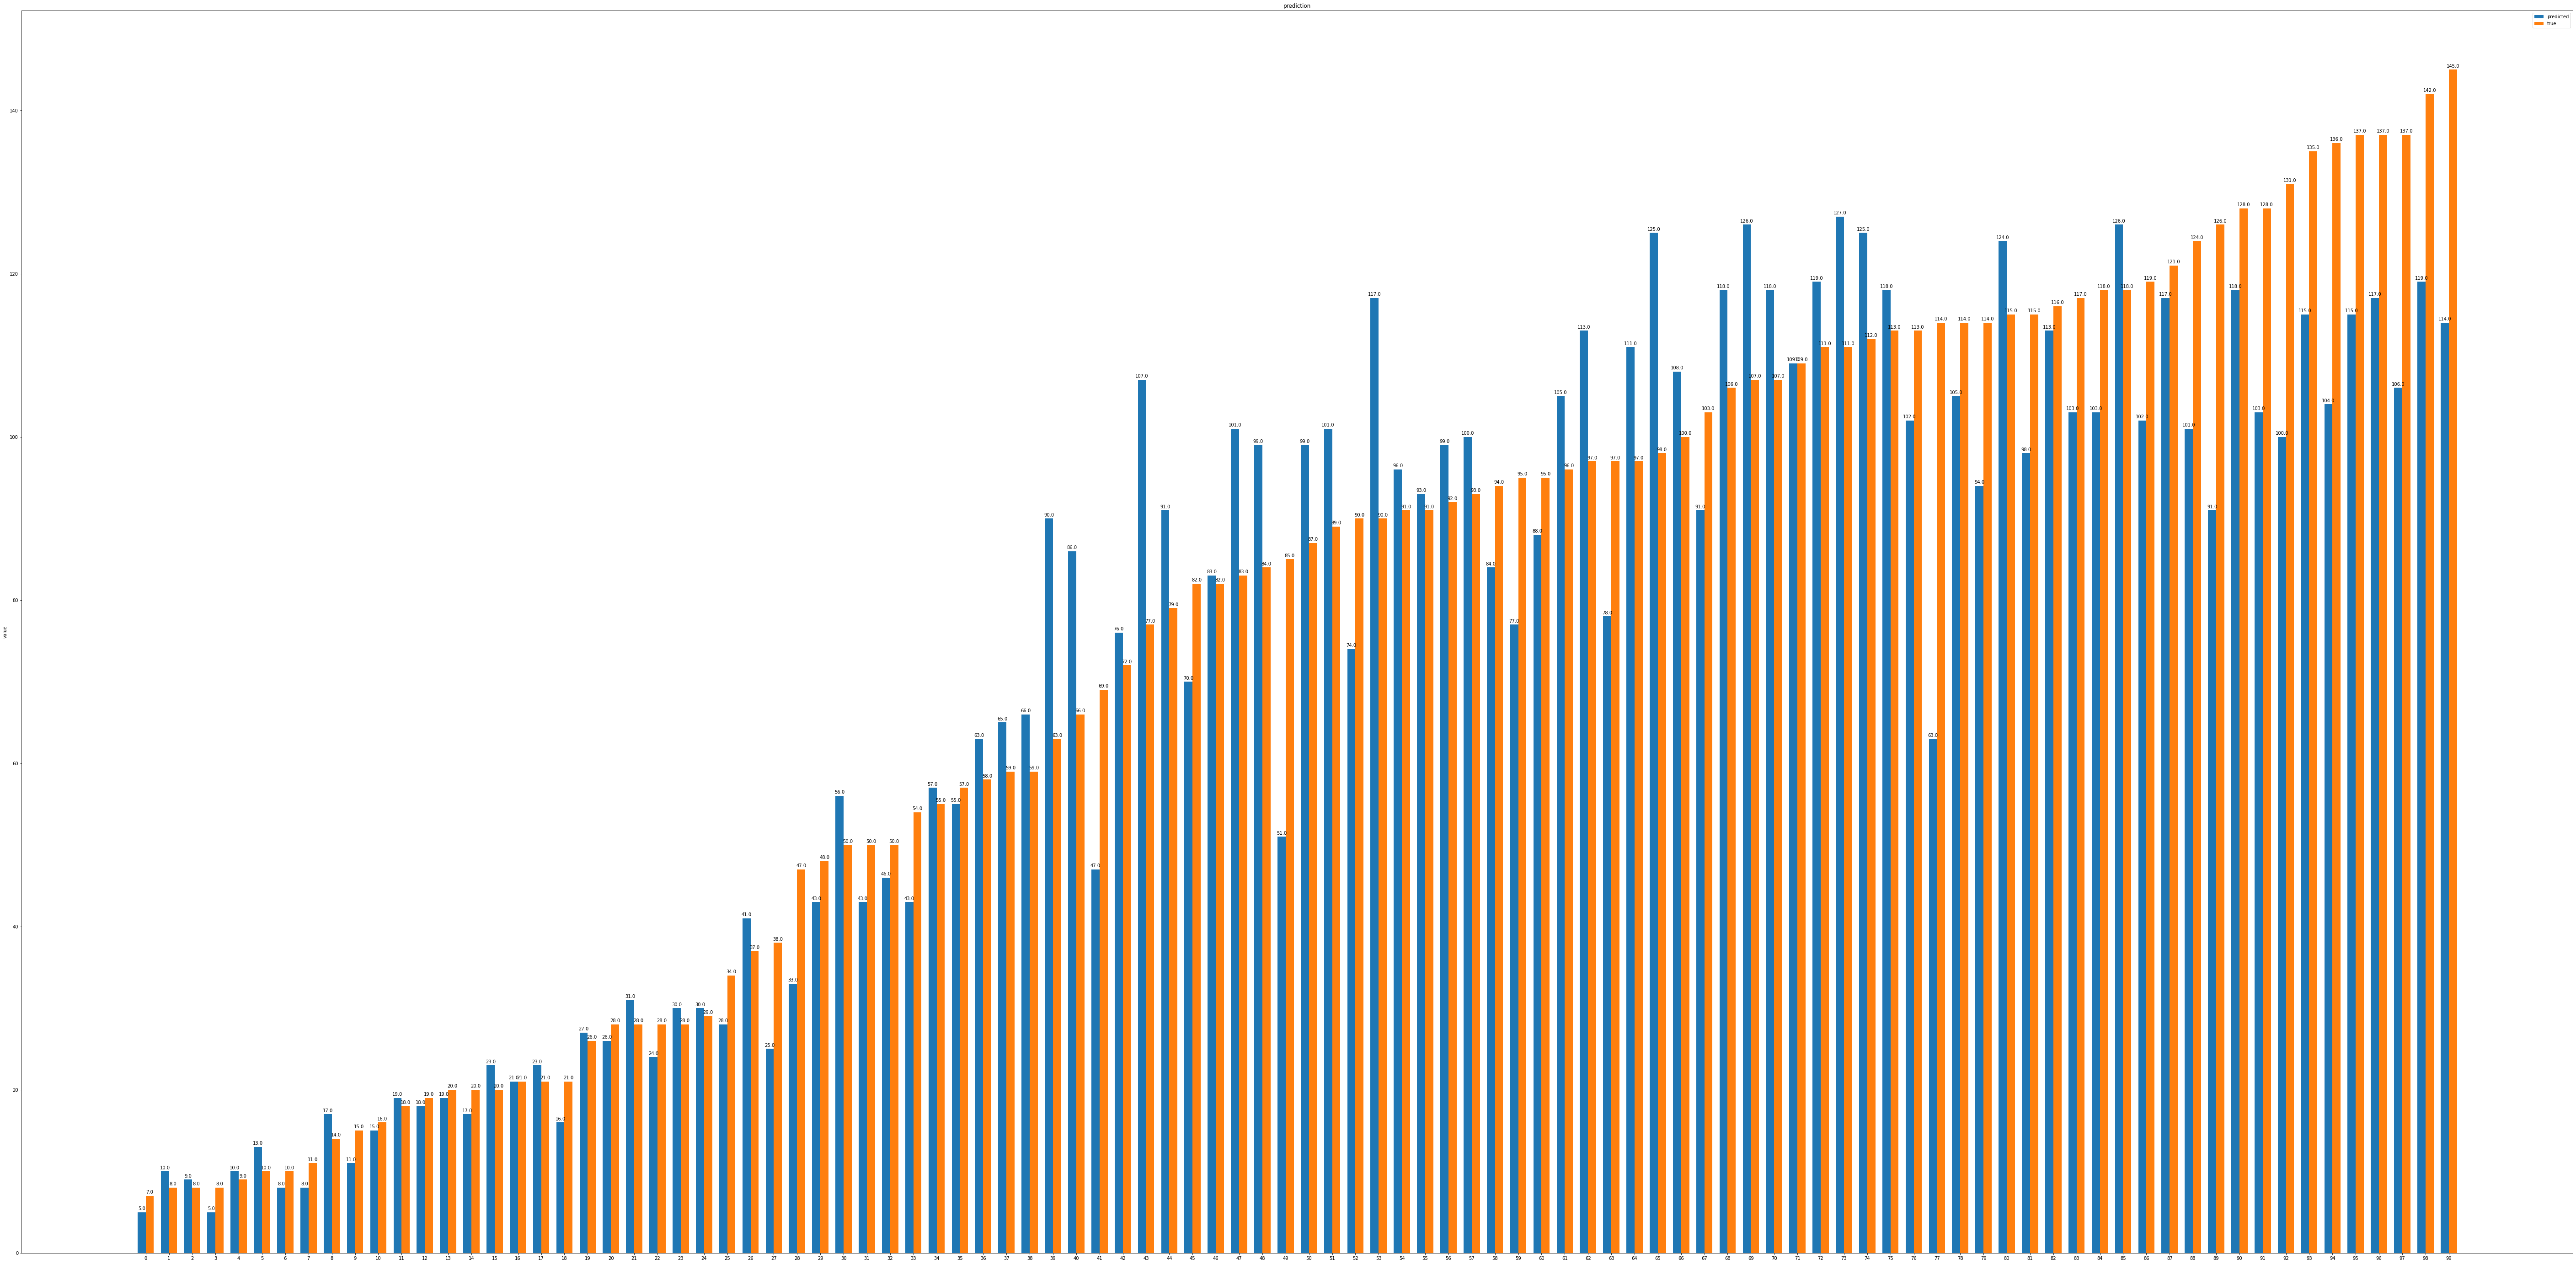

In [17]:
train_tcn(2,seq_array2,label_array2)


/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_model3.h5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 25)]          0         
_________________________________________________________________
tcn_4 (TCN)                  (None, 50, 12)            4692      
_________________________________________________________________
tcn_5 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________
Train on 14849 samples, validate on 782 samples
Epoch 1/100
14849/14849 - 20s - loss: 81.7822 - mae: 65.4243 - r2_keras: -3.2306e+00 - root_mean_squared_error: 81.5374 - val_loss: 55.152

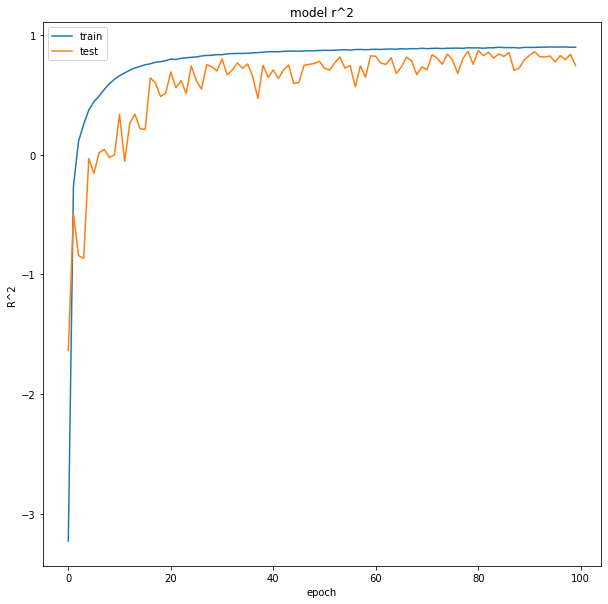

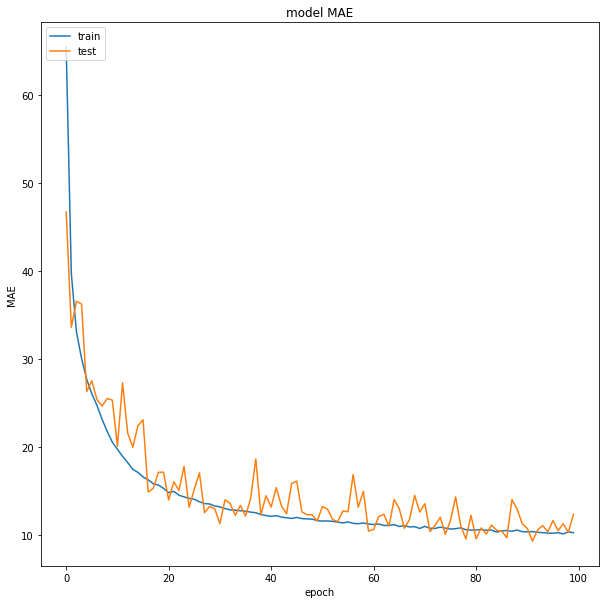

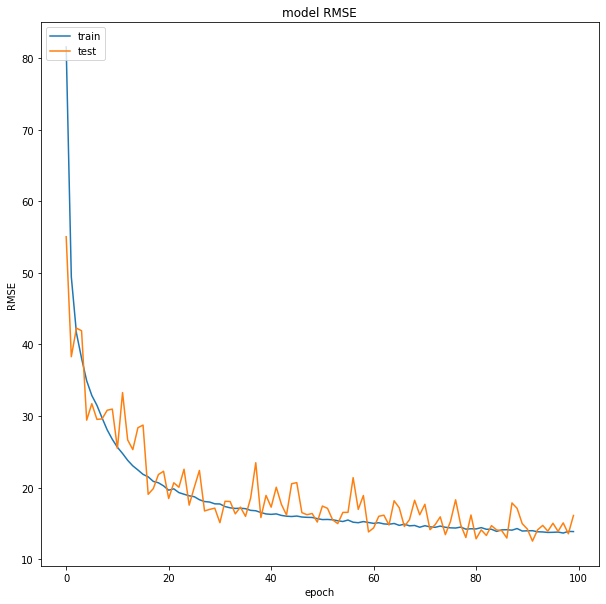

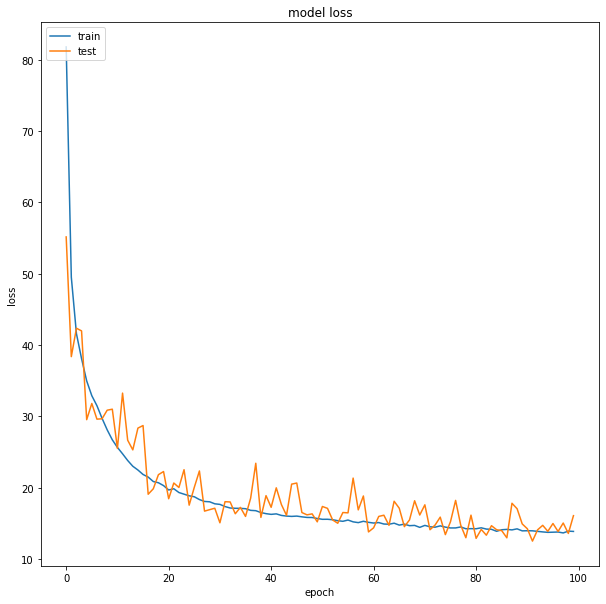

15631/15631 [==============================] - 5s 298us/sample - loss: 15.4200 - mae: 12.0525 - r2_keras: 0.8216 - root_mean_squared_error: 15.2895

MAE: 12.052530288696289

R^2: 0.8216341137886047

RMSE: 15.289475440979004
15631/15631 [==============================] - 5s 339us/sample
seq_array_test_last
(93, 50, 25)
(93, 1)
93/93 - 1s - loss: 14.8512 - mae: 10.5764 - r2_keras: 0.8659 - root_mean_squared_error: 14.9280

MAE: 10.576384544372559

R^2: 0.8659417033195496

RMSE: 14.927990913391113


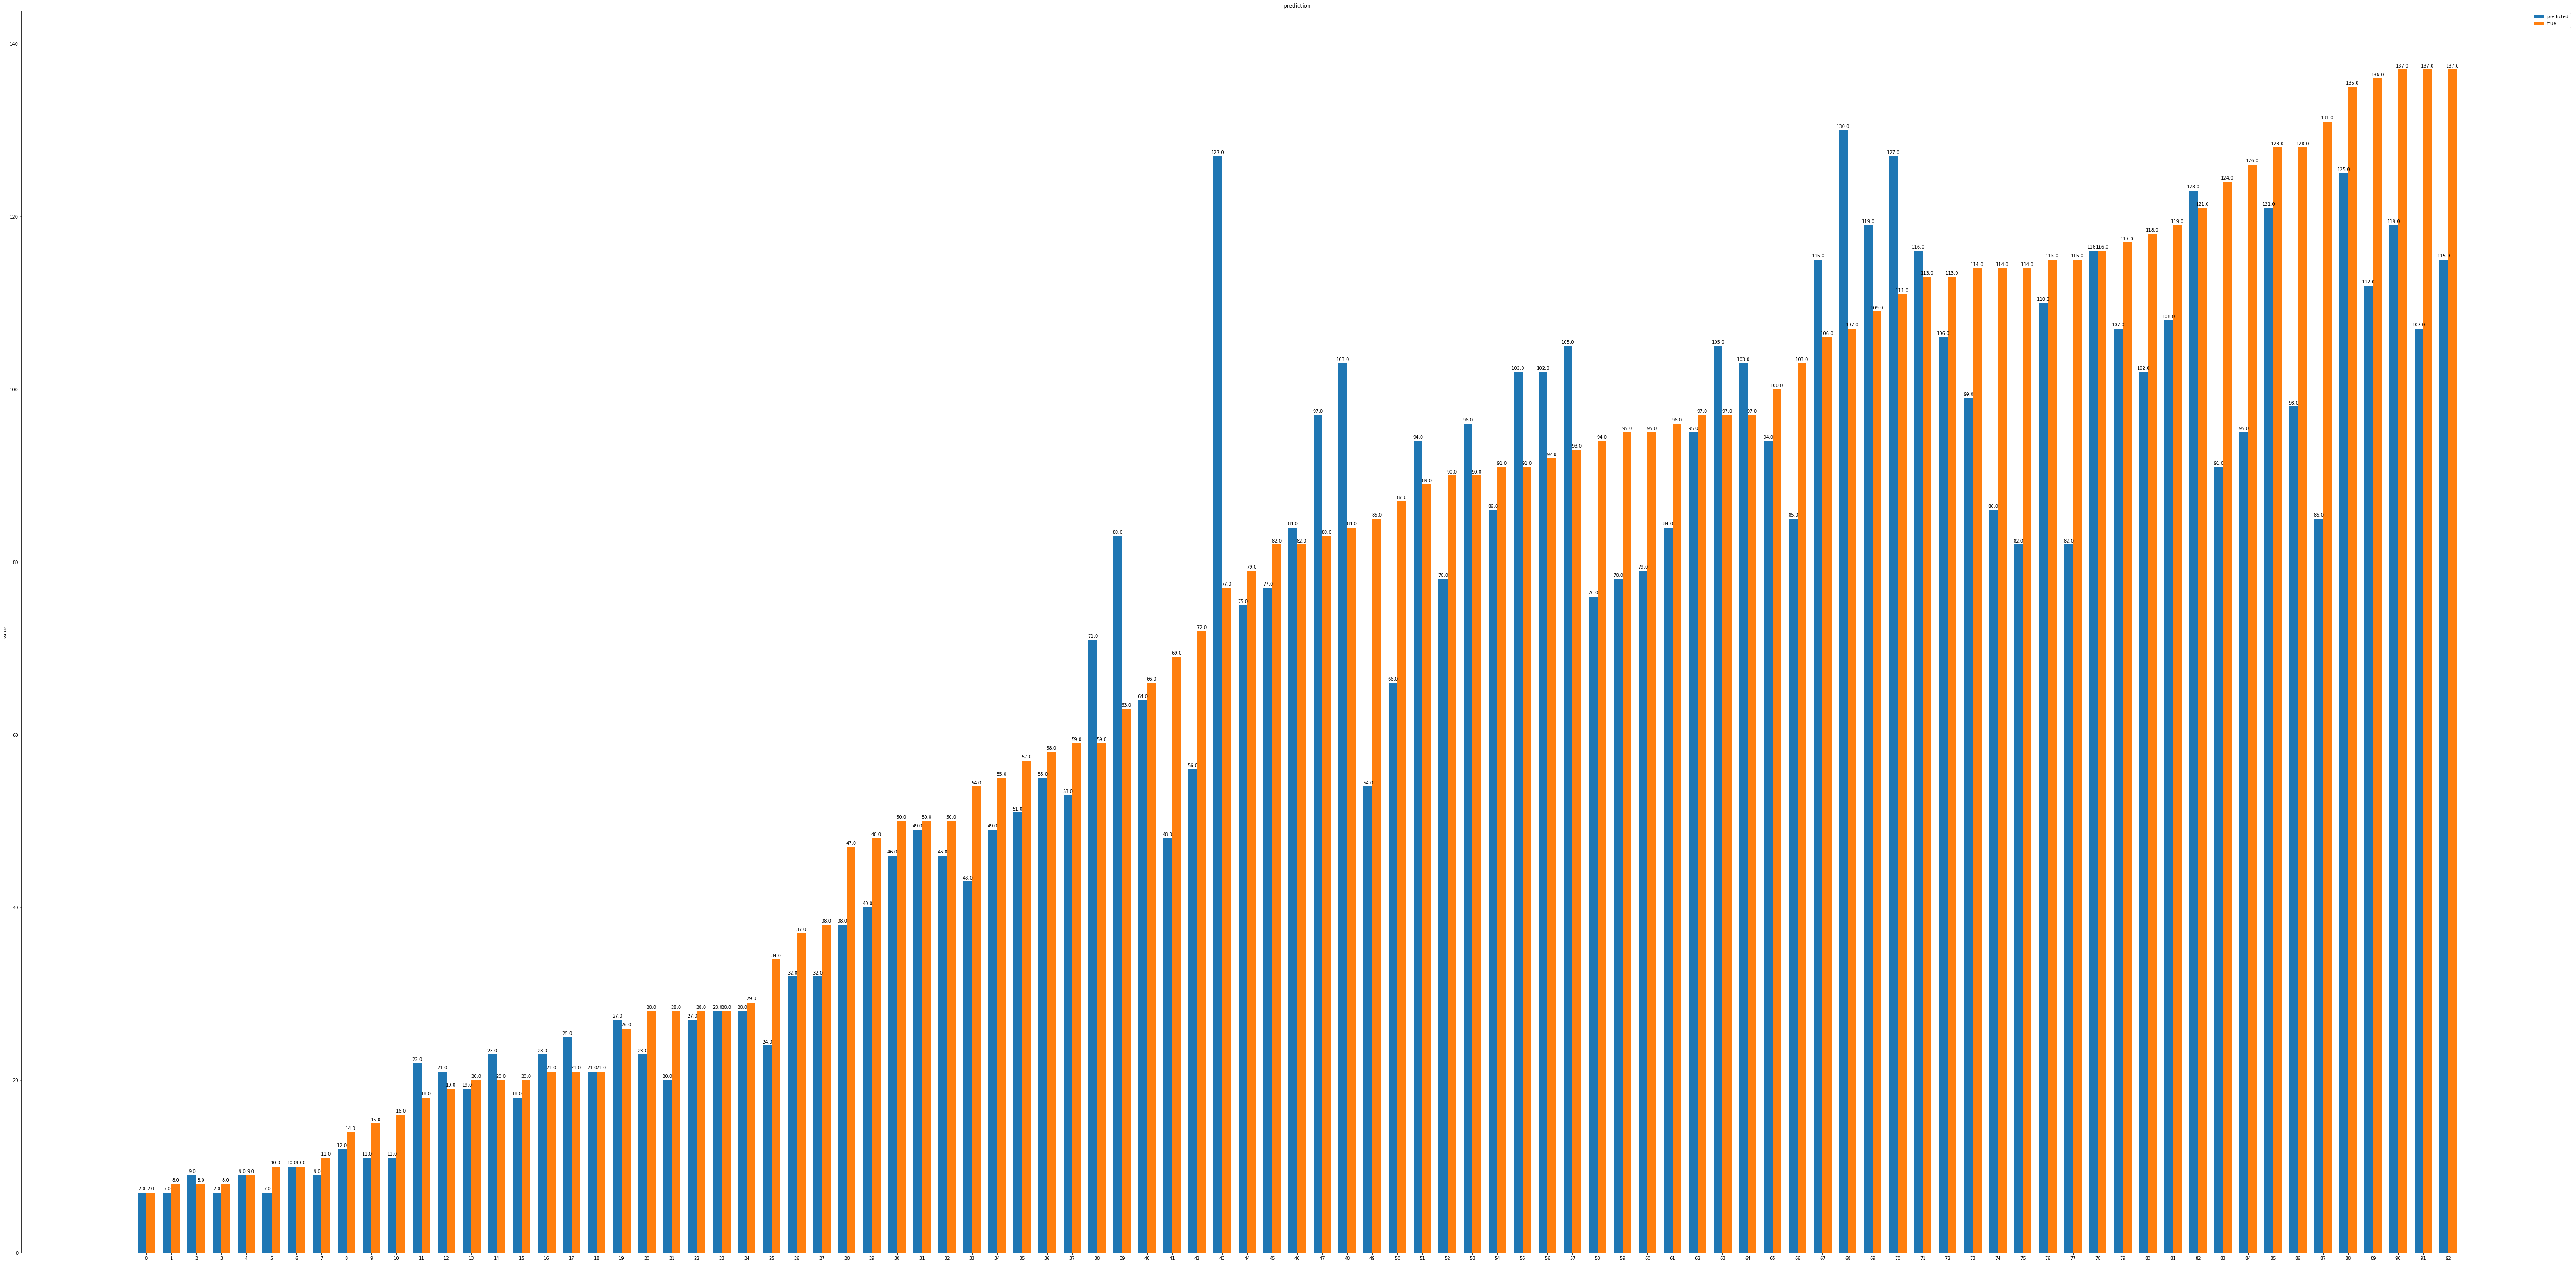

In [0]:
train_tcn(3,seq_array3,label_array3)


/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_model4.h5
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 70, 25)]          0         
_________________________________________________________________
tcn_6 (TCN)                  (None, 70, 12)            4692      
_________________________________________________________________
tcn_7 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________
Train on 12949 samples, validate on 682 samples
Epoch 1/100
12949/12949 - 21s - loss: 49.6533 - mae: 39.9413 - r2_keras: -3.5950e-01 - root_mean_squared_error: 49.6275 - val_loss: 44.309

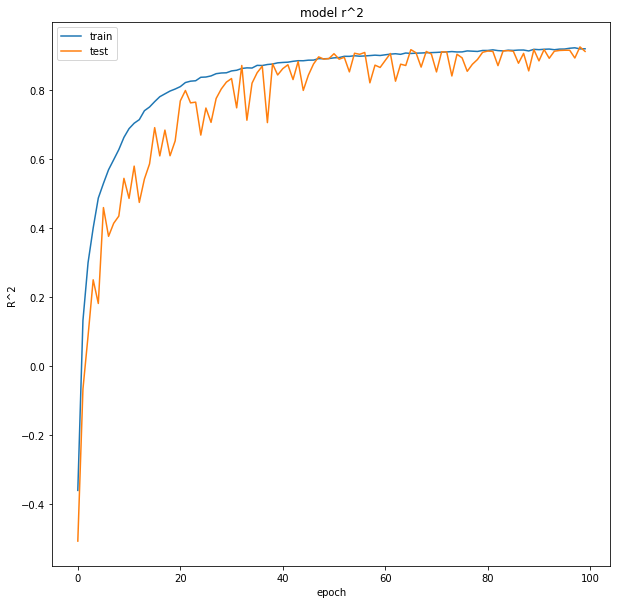

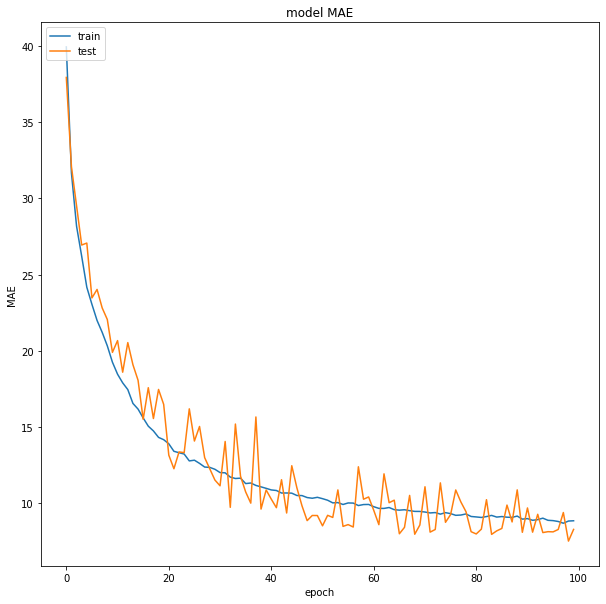

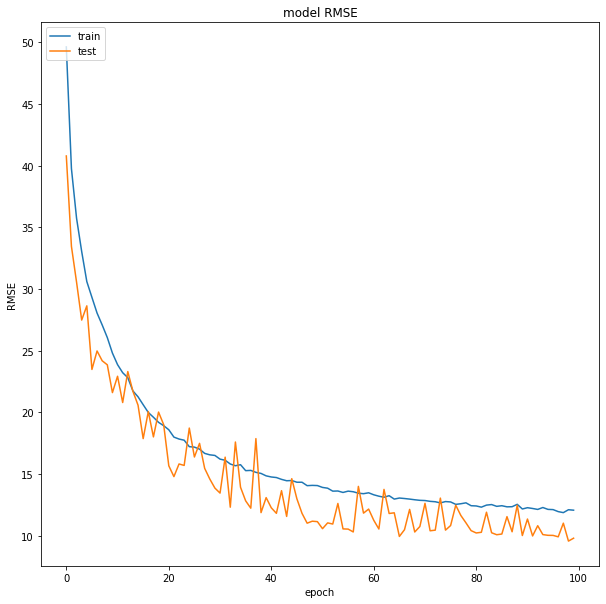

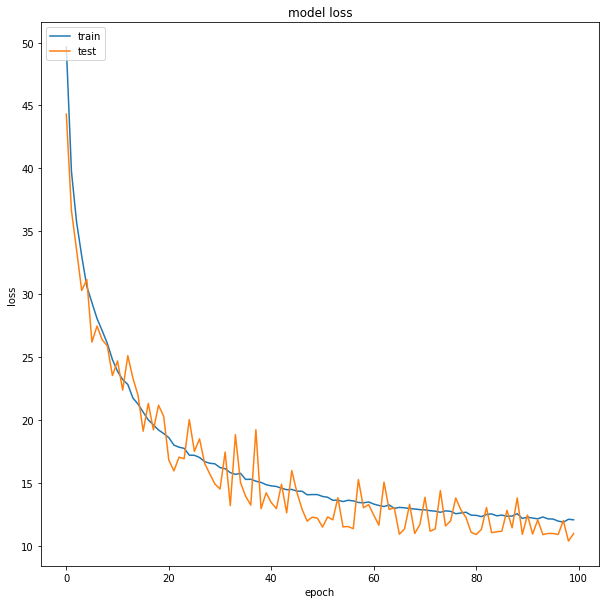

13631/13631 [==============================] - 5s 375us/sample - loss: 11.8593 - mae: 8.9381 - r2_keras: 0.9073 - root_mean_squared_error: 11.7492

MAE: 8.938101768493652

R^2: 0.907278835773468

RMSE: 11.749164581298828
13631/13631 [==============================] - 6s 422us/sample
seq_array_test_last
(86, 70, 25)
(86, 1)


KeyError: ignored

In [0]:
train_tcn(4,seq_array4,label_array4)


seq_array_test_last
(86, 70, 25)
(86, 1)
86/86 - 1s - loss: 13.0024 - mae: 9.1283 - r2_keras: 0.8967 - root_mean_squared_error: 13.2086

MAE: 9.128286361694336

R^2: 0.8967368602752686

RMSE: 13.208643913269043


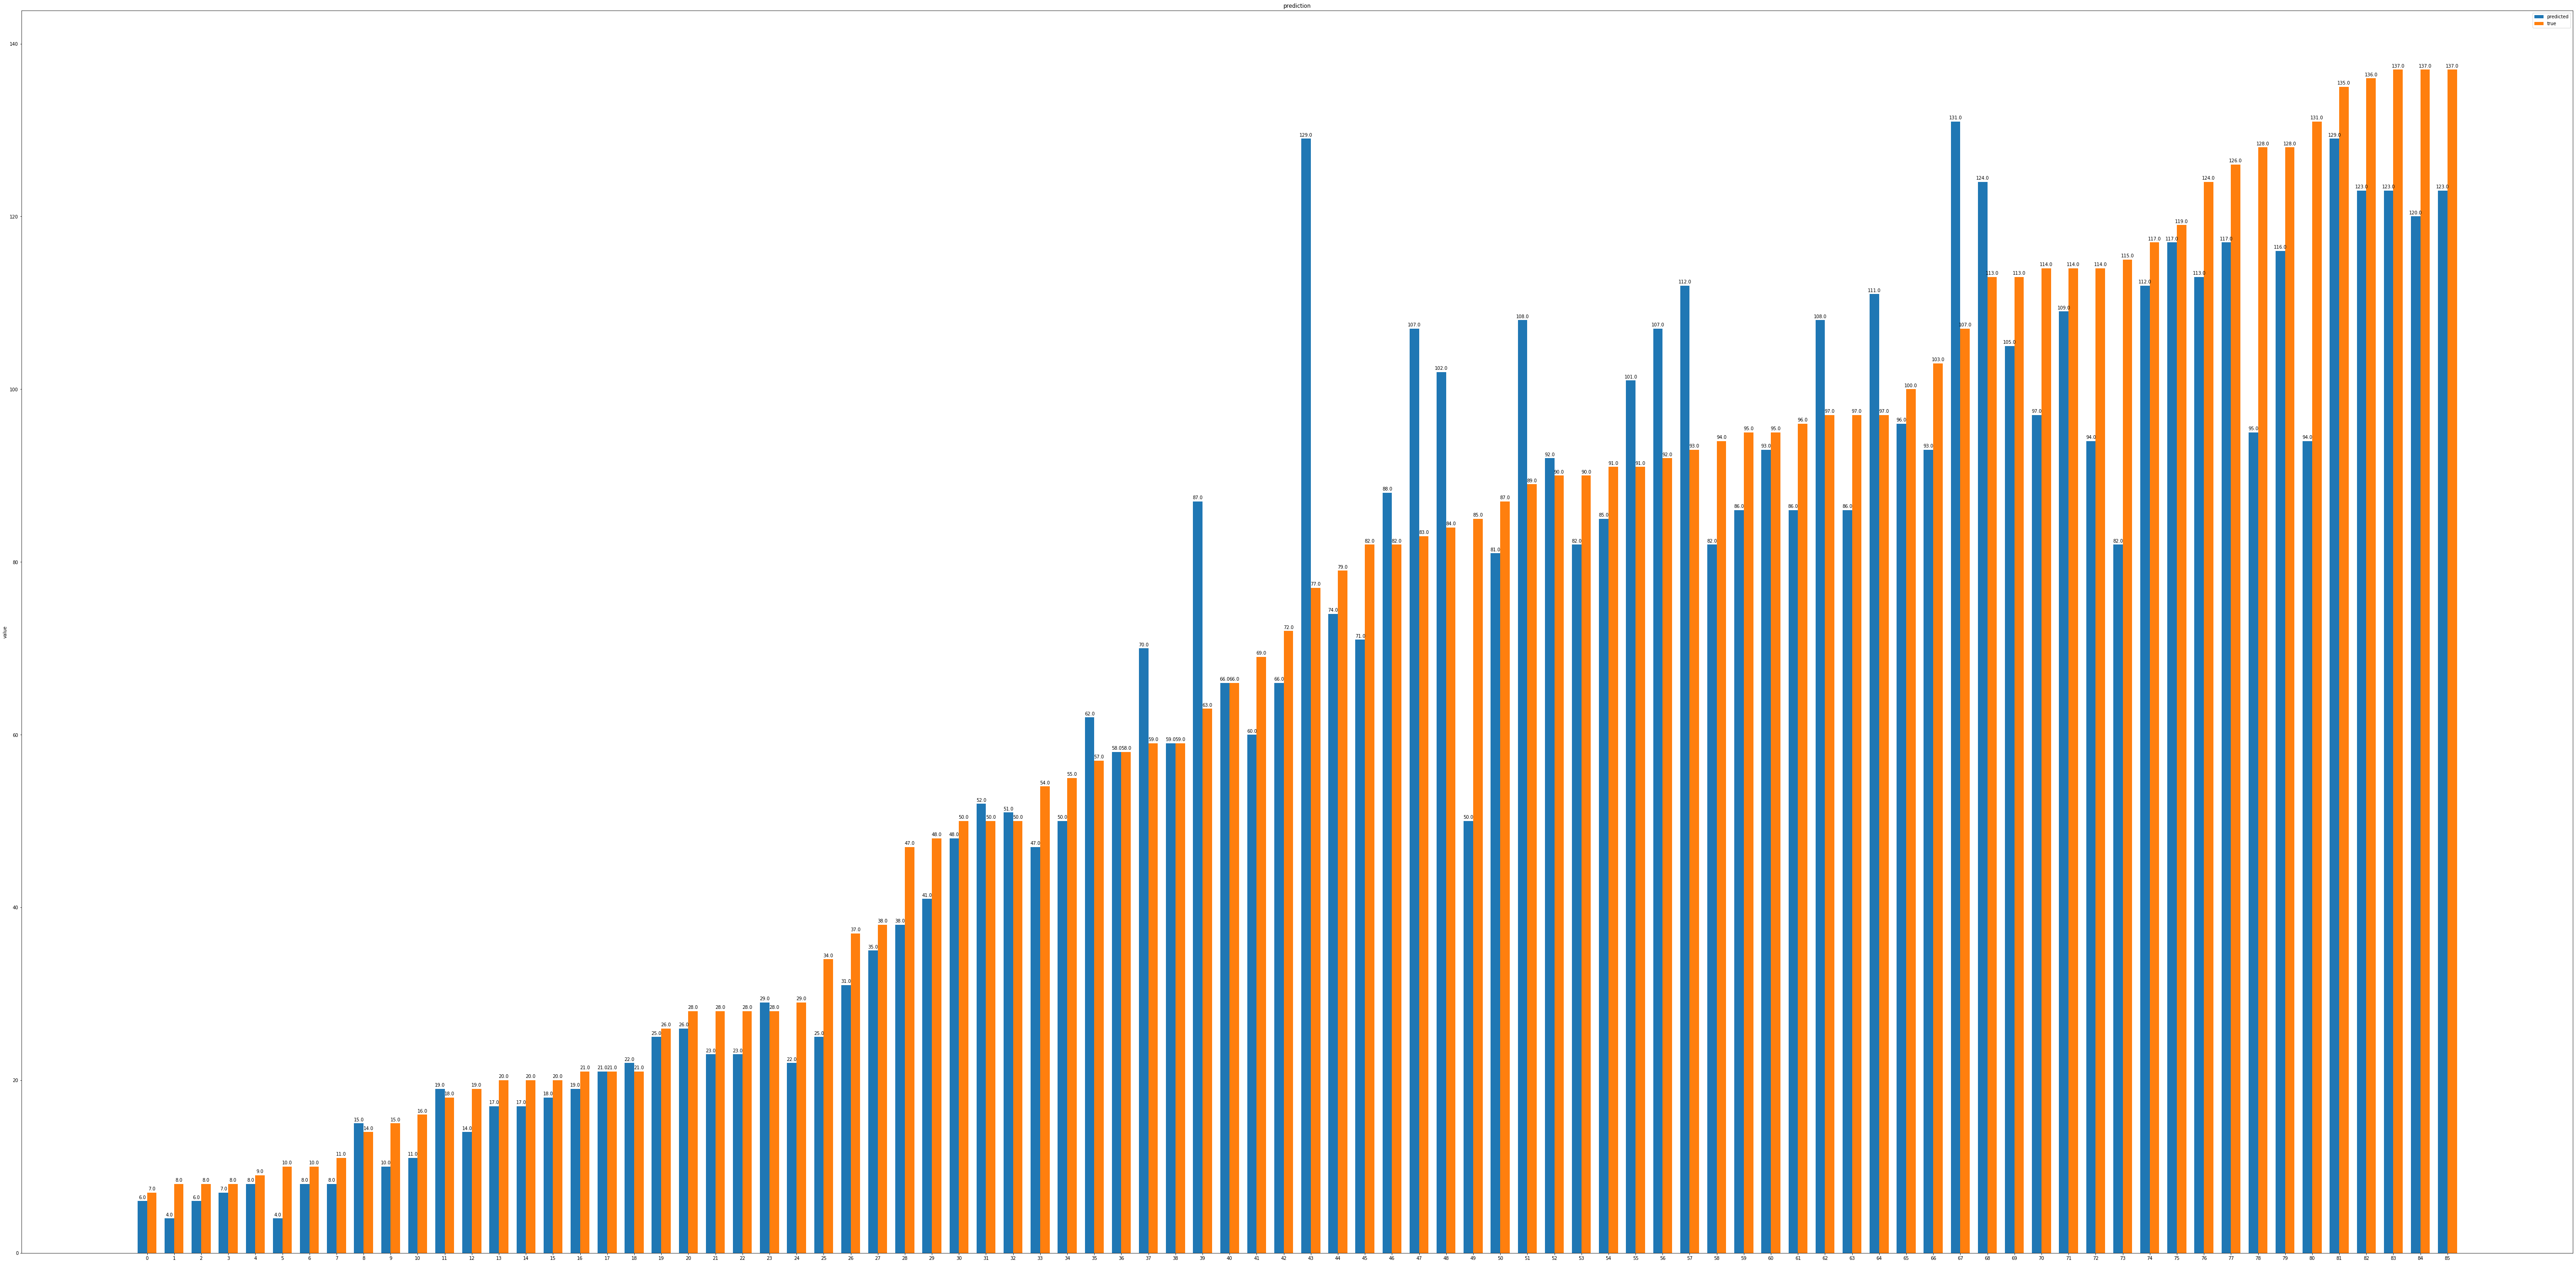

In [0]:

id = '4'
sequence_length = seq_array4.shape[1]
model_path = output_path+'/tcn_model'+ id +'.h5'

evaluate_on_test_data(model_path,id,sequence_length )

/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_model5.h5
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 90, 25)]          0         
_________________________________________________________________
tcn_8 (TCN)                  (None, 90, 12)            4692      
_________________________________________________________________
tcn_9 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________
Train on 11049 samples, validate on 582 samples
Epoch 1/100
11049/11049 - 20s - loss: 101.1721 - mae: 76.3962 - r2_keras: -6.9853e+00 - root_mean_squared_error: 100.7001 - val_loss: 60.0

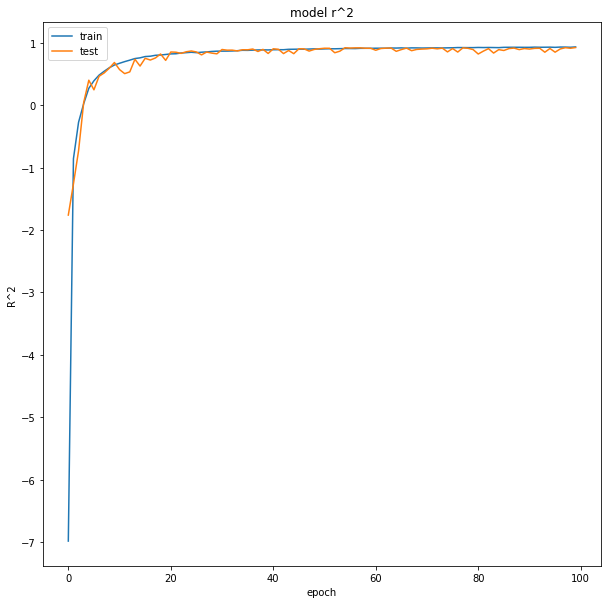

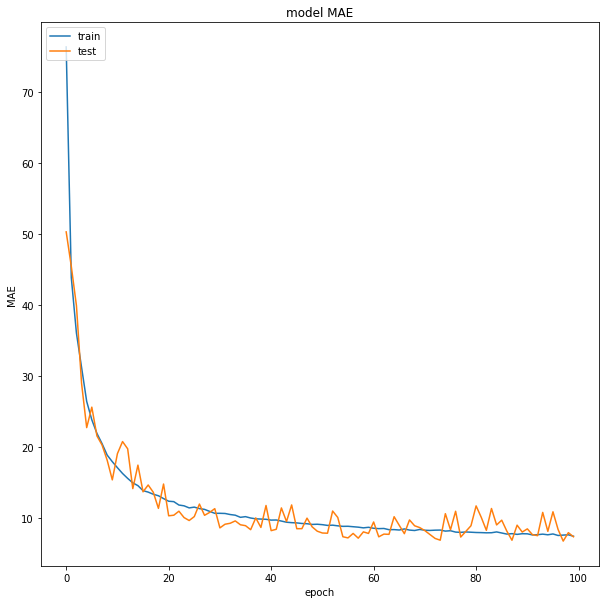

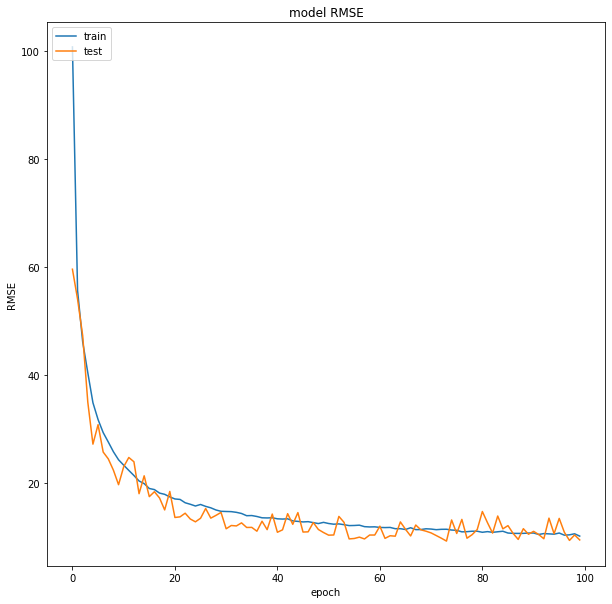

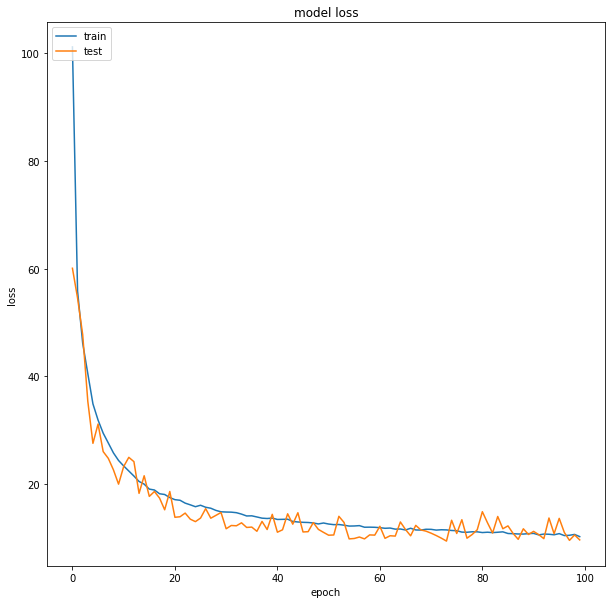

11631/11631 [==============================] - 5s 456us/sample - loss: 8.6157 - mae: 6.6336 - r2_keras: 0.9406 - root_mean_squared_error: 8.5474

MAE: 6.633642196655273

R^2: 0.9405836462974548

RMSE: 8.547444343566895
11631/11631 [==============================] - 6s 493us/sample
seq_array_test_last
(74, 90, 25)
(74, 1)
74/74 - 1s - loss: 10.2935 - mae: 7.3719 - r2_keras: 0.9325 - root_mean_squared_error: 10.2377

MAE: 7.37193489074707

R^2: 0.9325398802757263

RMSE: 10.2377290725708


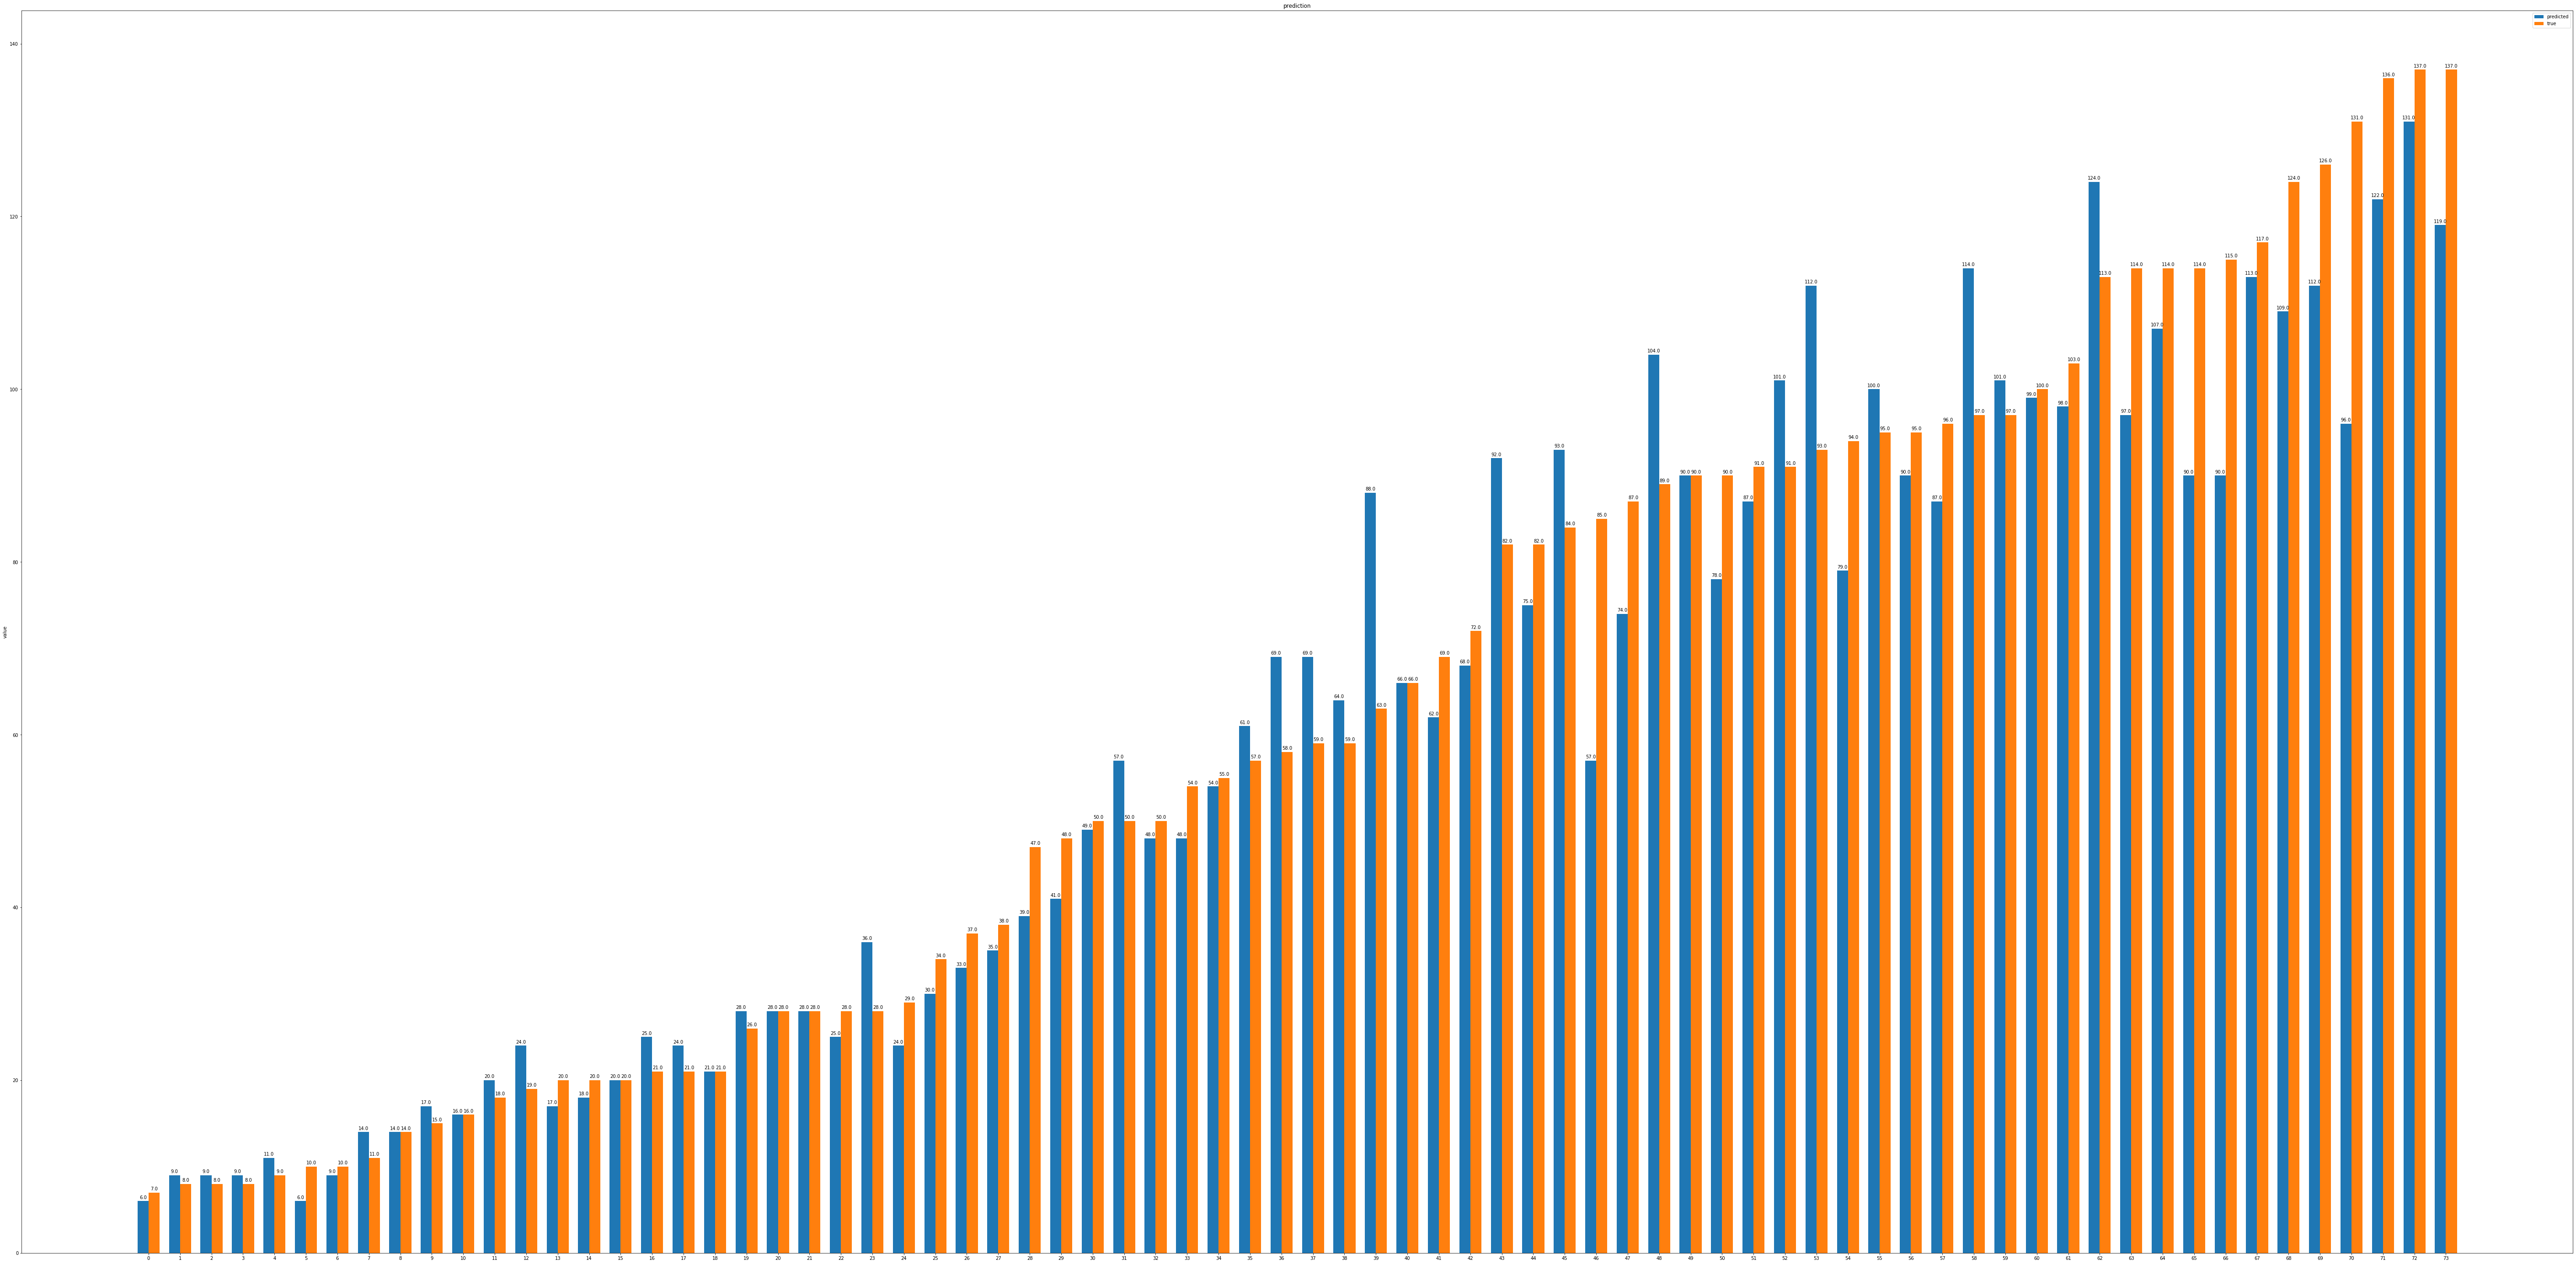

In [0]:
train_tcn(5,seq_array5,label_array5)


#FUSE models

In [0]:
seq_array1new  = seq_array5[:,-seq_array1.shape[1]:,]
seq_array2new  = seq_array5[:,-seq_array2.shape[1]:,]
seq_array3new  = seq_array5[:,-seq_array3.shape[1]:,]
seq_array4new  = seq_array5[:,-seq_array4.shape[1]:,]

In [0]:
def get_encoded_data(model_path,data):
  if os.path.isfile(model_path):

      # restore weights

      model = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error': root_mean_squared_error,'TCN': TCN})
      estimator_model = Model(inputs=model.inputs, outputs=model.layers[2].output)
      #estimator_model.summary()
      encoded_data = estimator_model.predict(data,verbose=1, batch_size=200)
      return encoded_data

In [0]:
data1 = get_encoded_data(output_path+'/tcn_model1.h5',seq_array1new)
data2 = get_encoded_data(output_path+'/tcn_model2.h5',seq_array2new)
data3 = get_encoded_data(output_path+'/tcn_model3.h5',seq_array3new)
data4 = get_encoded_data(output_path+'/tcn_model4.h5',seq_array4new)
data5 = get_encoded_data(output_path+'/tcn_model5.h5',seq_array5)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 25)]          0         
_________________________________________________________________
tcn_8 (TCN)                  (None, 10, 12)            4692      
_________________________________________________________________
tcn_9 (TCN)                  (None, 6)                 1224      
Total params: 5,916
Trainable params: 5,916
Non-trainable params: 0
_________________________________________________________________
11631/11631 [==============================] - 2s 158us/sample
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 25)]          0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 30, 12)

In [0]:
seq_array_new = pd.concat([pd.DataFrame(data1),pd.DataFrame(data2),pd.DataFrame(data3),pd.DataFrame(data4),pd.DataFrame(data5)], axis=1, sort=False)

In [0]:
seq_array_new.head()

,0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5
0,32.273304,106.664055,0.0,37.593910,0.947136,0.00000,14.115763,1.079038,61.787140,4.747606,6.952765,88.816978,27.900875,50.158688,8.678980,12.240211,9.635218,104.601288,23.408138,80.074417,0.0,21.704720,131.504013,8.993840,21.408009,41.061871,126.921707,0.810990,0.000000,0.511961
1,36.364719,104.780716,0.0,39.568092,1.323248,0.00000,13.883032,0.000000,61.452896,2.516599,5.523109,90.808594,29.978716,50.674366,8.998378,13.570133,10.377186,109.584206,24.192280,79.444885,0.0,25.397627,135.848099,7.838536,22.443403,44.317280,128.223068,0.616156,0.000000,0.452886
2,30.601992,106.934074,0.0,40.926064,1.219027,0.00000,14.152363,0.582064,61.173286,2.724453,5.411419,90.366249,26.110100,47.072609,7.253942,13.233595,7.741228,100.822327,22.231853,76.460350,0.0,21.430111,129.441086,7.695312,20.474621,36.842098,124.086380,1.284820,0.301204,1.205894
3,27.355177,101.284904,0.0,29.966677,0.578091,0.12403,9.395797,0.460157,59.964981,1.702458,4.994480,85.768883,25.760960,47.719635,9.411418,9.149581,8.391777,103.473625,22.607010,79.194511,0.0,19.589706,129.091705,8.031713,20.383919,41.238201,125.748886,1.758603,0.179351,0.445059
4,29.578102,101.402374,0.0,34.544132,0.726407,0.00000,8.149275,0.586659,57.418140,2.135818,4.602520,82.011513,24.654684,47.478996,10.629972,6.093679,6.864219,101.979050,22.474749,73.668427,0.0,17.915485,126.862907,6.062303,19.381115,32.043018,120.805351,1.351619,0.040681,1.048422


In [0]:
# Train Dense model:
##output tcn-6 
model_path = output_path+'/tcn_fuse_dense_model.h5'
print(model_path)
nb_features = seq_array_new.shape[1]
nb_out = label_array5.shape[1]


i = Input(shape=( nb_features))

#m = TCN(nb_filters=12,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=True)(i)
#m = TCN(nb_filters=6,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=False)(m)

m = Dense(1, activation='linear')(i)
model = Model(inputs=[i], outputs=[m])
model.summary()

model.compile('adam', 'mae')
model.compile(loss=root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])

history = model.fit(seq_array_new, label_array5, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                      keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

/content/drive/My Drive/Fax/Master Theses/output-tcn-6/tcn_fuse_dense_model.h5
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Train on 11049 samples, validate on 582 samples
Epoch 1/100
11049/11049 - 1s - loss: 14.6657 - mae: 11.3129 - r2_keras: 0.8527 - root_mean_squared_error: 14.6153 - val_loss: 10.7635 - val_mae: 7.8651 - val_r2_keras: 0.8836 - val_root_mean_squared_error: 10.6835
Epoch 2/100
11049/11049 - 0s - loss: 9.4508 - mae: 6.8270 - r2_keras: 0.9469 - root_mean_squared_error: 9.4113 - val_loss: 10.5605 - val_mae: 7.6142 - val_r2_keras: 0.8900 - val_root_

dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


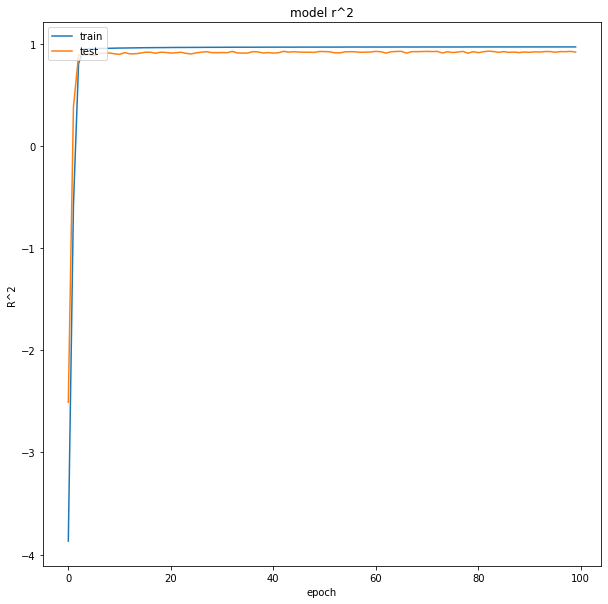

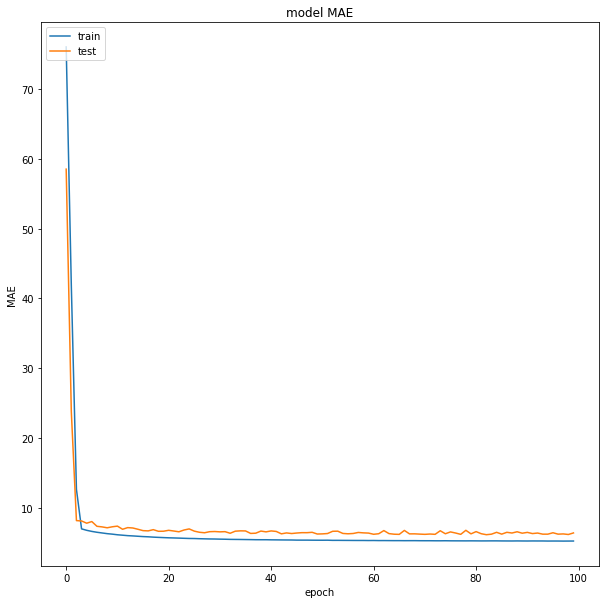

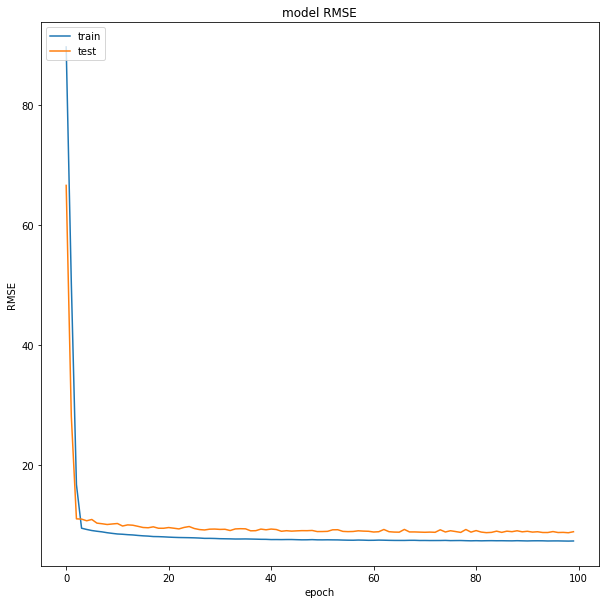

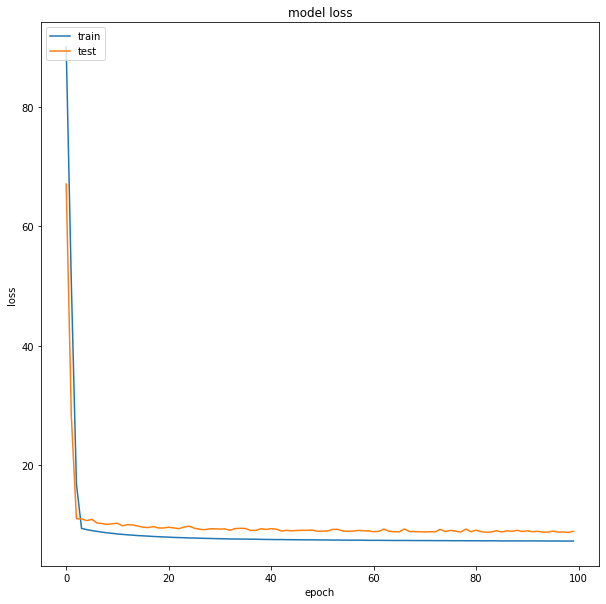

11631/11631 [==============================] - 0s 6us/sample - loss: 7.2278 - mae: 5.3029 - r2_keras: 0.9547 - root_mean_squared_error: 7.1519

MAE: 5.302939414978027

R^2: 0.9546866416931152

RMSE: 7.151933670043945
11631/11631 [==============================] - 0s 6us/sample


In [0]:
plot_stats(history,model,'_fuse_dense', seq_array_new,label_array5)

In [0]:
def get_test_data_tcn(model_path,sequence_length,sequence_length_max ):
  # We pick the last sequence for each id in the test data
  seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length_max]

  seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
  #print("seq_array_test_last")
  #print(seq_array_test_last.shape)

  return get_encoded_data(model_path,seq_array_test_last)
      

In [0]:
test_data1 = get_test_data_tcn(output_path+'/tcn_model1.h5',seq_array1new.shape[1],seq_array5.shape[1])
test_data2 = get_test_data_tcn(output_path+'/tcn_model2.h5',seq_array2new.shape[1],seq_array5.shape[1])
test_data3 = get_test_data_tcn(output_path+'/tcn_model3.h5',seq_array3new.shape[1],seq_array5.shape[1])
test_data4 = get_test_data_tcn(output_path+'/tcn_model4.h5',seq_array4new.shape[1],seq_array5.shape[1])
test_data5 = get_test_data_tcn(output_path+'/tcn_model5.h5',seq_array5.shape[1],seq_array5.shape[1])


74/74 [==============================] - 1s 8ms/sample


In [0]:
seq_array_test_new = pd.concat([pd.DataFrame(test_data1),pd.DataFrame(test_data2),pd.DataFrame(test_data3),pd.DataFrame(test_data4),pd.DataFrame(test_data5)], axis=1, sort=False)

(74, 1)
74/74 - 0s - loss: 10.1306 - mae: 6.8697 - r2_keras: 0.9321 - root_mean_squared_error: 10.2445

MAE: 6.869684219360352

R^2: 0.9321147799491882

RMSE: 10.2445068359375


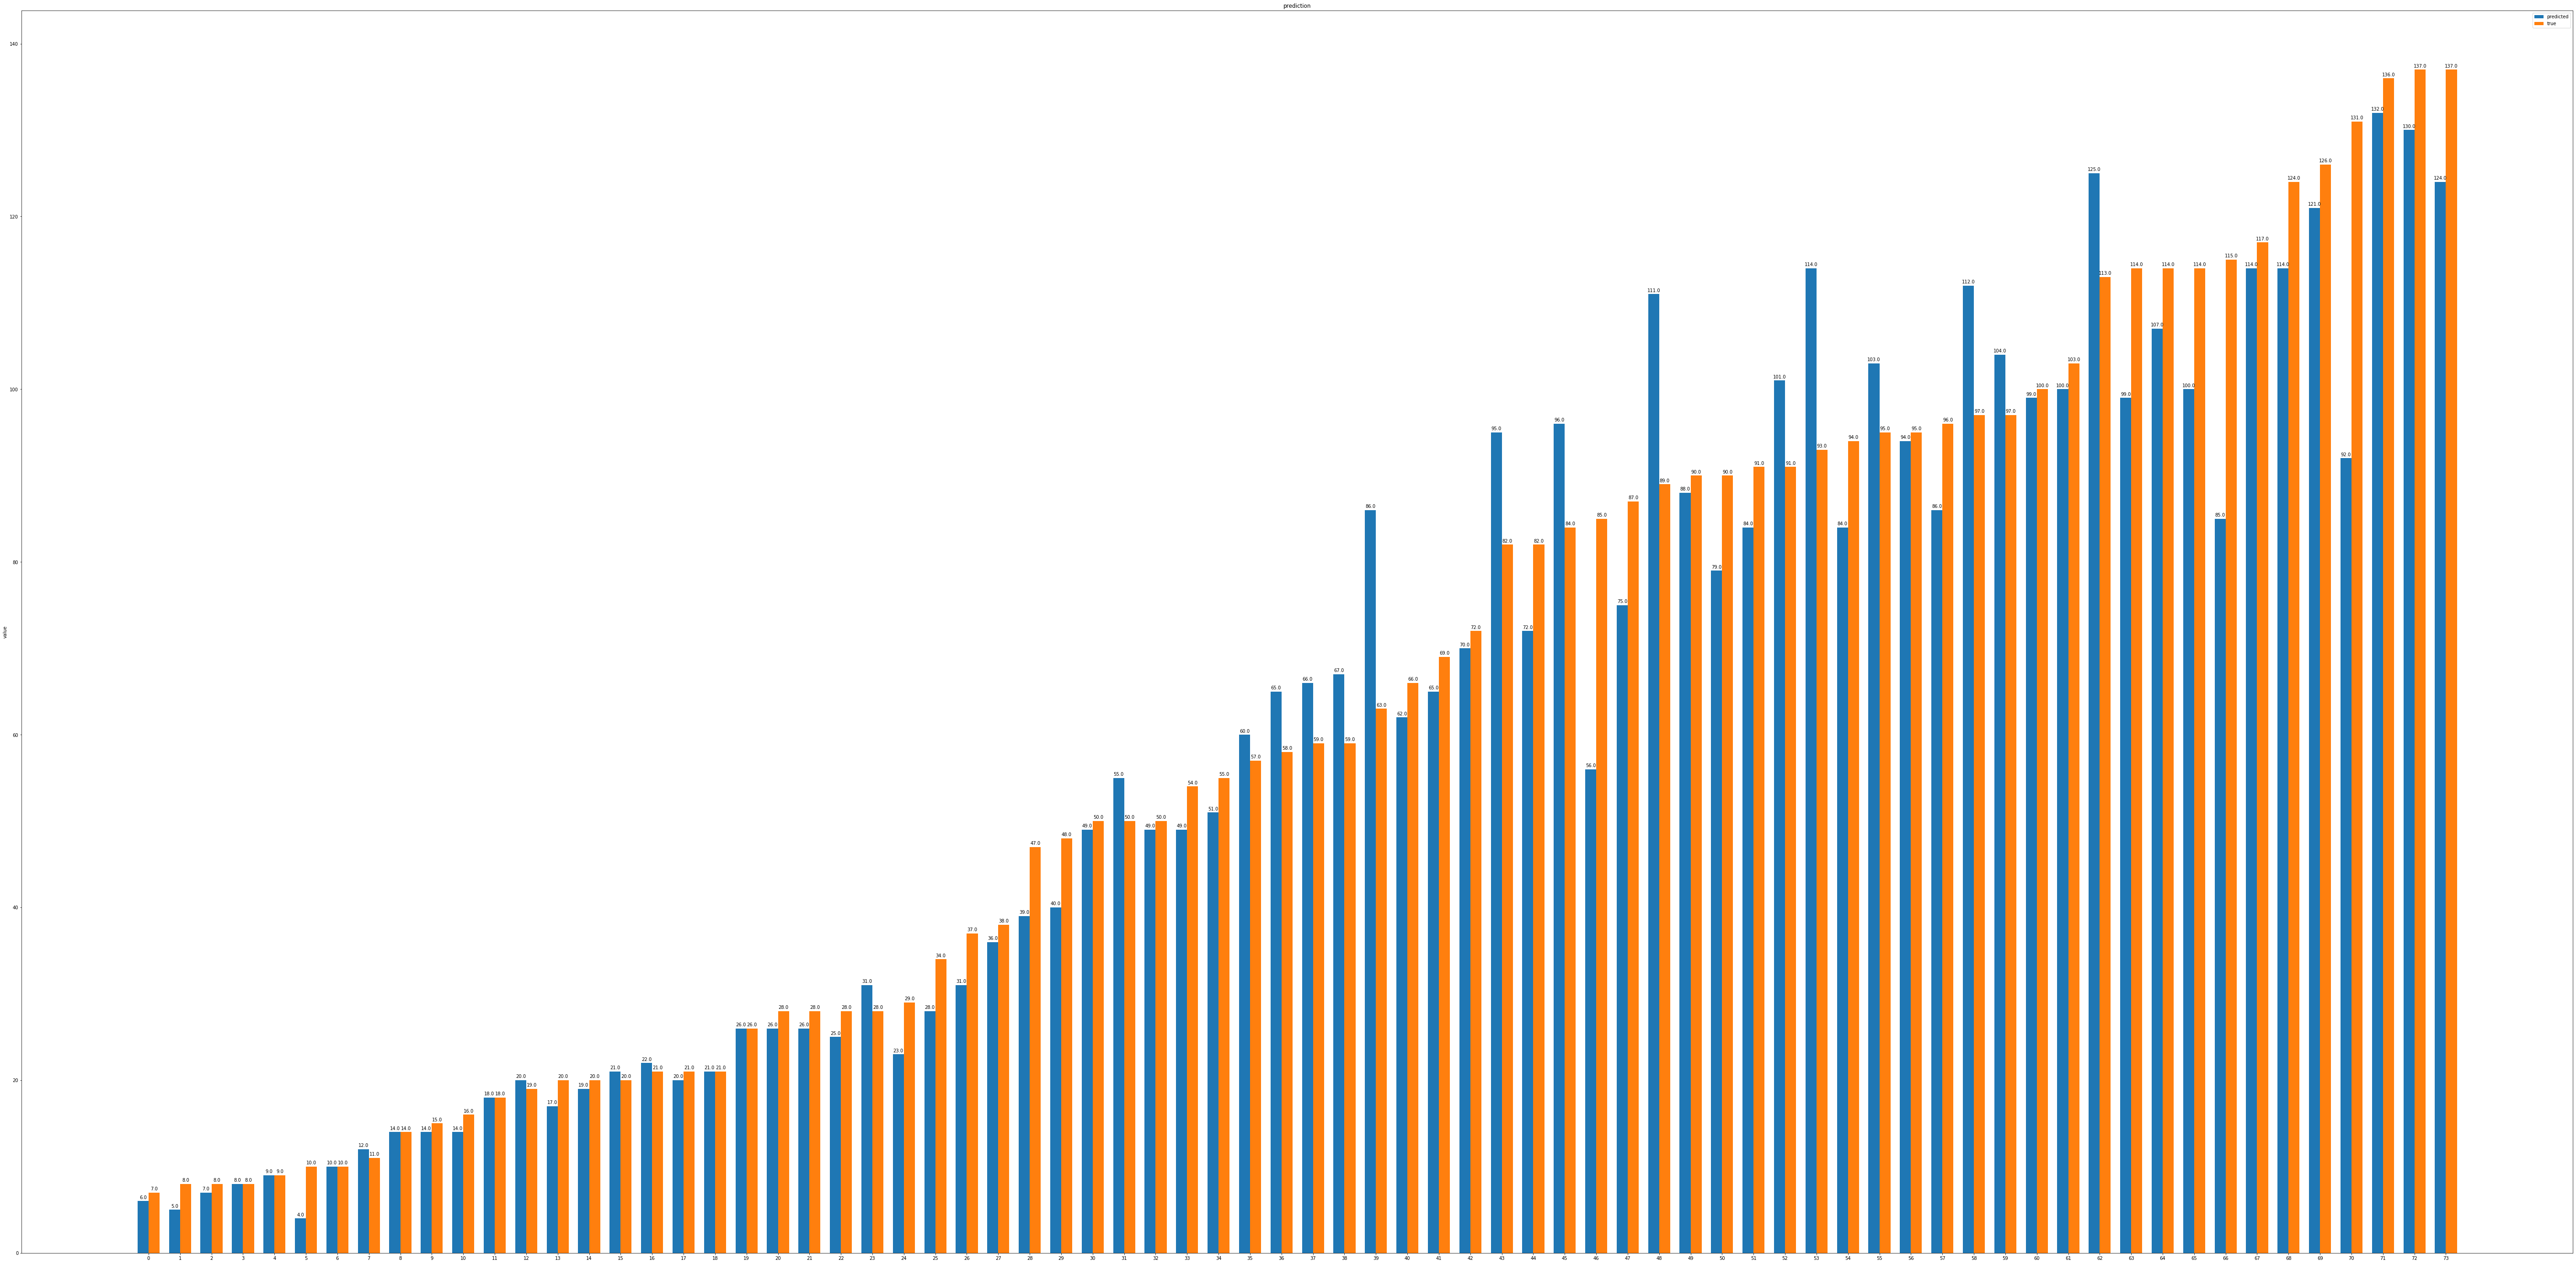

In [0]:
##################################
# EVALUATE ON TEST DATA
##################################
#def evaluate_on_test_data(model_path,id,sequence_length ):
  dense_model_path = output_path+'/tcn_fuse_dense_model.h5'
  # We pick the last sequence for each id in the test data
  
  sequence_length = seq_array5.shape[1]
  # Similarly, we pick the labels
  
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
  label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
  print(label_array_test_last.shape)
  #print("label_array_test_last")
  #print(label_array_test_last)

  # if best iteration's model was saved then load and use it
  if os.path.isfile(dense_model_path):

      # restore weights
      estimator = load_model(dense_model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error': root_mean_squared_error})

      
      # test metrics
      scores_test = estimator.evaluate(seq_array_test_new, label_array_test_last, verbose=2)
      print('\nMAE: {}'.format(scores_test[1]))
      print('\nR^2: {}'.format(scores_test[2]))
      print('\nRMSE: {}'.format(scores_test[3]))

      y_pred_test = estimator.predict(seq_array_test_new)
      y_true_test = label_array_test_last

      test_set = pd.DataFrame(y_pred_test)
      test_set.to_csv(output_path+'/submit_test_fuse_dense.csv', index = None)



      result = pd.DataFrame( columns = ['pred', 'true']) 
      result['pred'] = y_pred_test.flatten().round()
      result['true'] = y_true_test.flatten()
      result.sort_values(by='true', inplace=True)
      # Plot in blue color the predicted data and in orange color the
      # actual data to verify visually the accuracy of the model.
          
      x = np.arange(len(y_pred_test))
      width = 0.35  # the width of the bars

      fig, ax = plt.subplots(figsize=(100, 50))
      rects1 = ax.bar(x - width/2,result['pred'], width, label='predicted')
      rects2 = ax.bar(x + width/2,result['true'], width, label='true')

      # Add some text for labels, title and custom x-axis tick labels, etc.
      ax.set_ylabel('value')
      ax.set_title('prediction')
      ax.set_xticks(x)
      ax.legend()


      def autolabel(rects):
          """Attach a text label above each bar in *rects*, displaying its height."""
          for rect in rects:
              height = rect.get_height()
              ax.annotate('{}'.format(height),
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom')


      autolabel(rects1)
      autolabel(rects2)

      plt.show()
      fig.savefig(output_path+"/model_fuse_dense_verify_bar.png")